## 1. 👥 Customer Demographics Analysis

# Bank Churn Analysis

## Data analysis and modeling pipeline for predicting customer churn.



In [334]:
# --- Import Necessary Libraries ---  
import os  
import json  
from pathlib import Path  
import warnings  
import sys  
  
# Standard Library Imports  
import pandas as pd  
import numpy as np  
from IPython.display import display  
  
# Third-Party Imports  
import plotly.express as px  
import plotly.graph_objects as go  
import plotly.io as pio 
from plotly.subplots import make_subplots   
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder  
from sklearn.compose import ColumnTransformer  
from sklearn.pipeline import Pipeline  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import (  
    classification_report,   
    confusion_matrix,   
    roc_auc_score,   
    roc_curve  
)  
from sklearn.linear_model import LogisticRegression
from scipy import stats
# Configuration Constants

CONFIG = {
    'AGE_BINS': [0, 30, 40, 50, 60, 100],
    'AGE_LABELS': ['<30', '30-40', '41-50', '51-60', '60+'],
    'BALANCE_SEGMENTS': 3,
    'CREDIT_SCORE_BINS': [300, 580, 670, 740, 800, 850],
    'CREDIT_SCORE_LABELS': ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
}

# Initialize Insights Dictionary  
insights = {
    'attributes_common_among_churners': {},
    'geography_account_behavior': {},
    'demographic_analysis': {},
    'correlation_analysis': {},
    'can_predict_churn': {},
    'segmentation_analysis': {}
}

# Suppress warnings  
warnings.filterwarnings('ignore')  
  
# Configure Plotly Layout Defaults  
pio.templates.default = "plotly_white"  
  
# Initialize Insights Dictionary  
insights = {
    'attributes_common_among_churners': {},
    'geography_account_behavior': {},
    'demographic_analysis': {},
    'correlation_analysis': {},
    'can_predict_churn': {},
    'segmentation_analysis': {}
}

# --- Define Functions ---  
  
def load_bank_data(file_path: str) -> pd.DataFrame:  
    """  
    Load bank churn data from a CSV file.  
  
    Args:  
        file_path (str): The path to the CSV file.  
  
    Returns:  
        pd.DataFrame: The loaded data as a Pandas DataFrame.  
    """  
    try:  
        df = pd.read_csv(file_path)  
        print(f"✅ Data loaded successfully from {file_path}")  
        return df  
    except FileNotFoundError:  
        print(f"❌ File not found at path: {file_path}")  
        return pd.DataFrame()  
    except Exception as e:  
        print(f"❌ An error occurred while loading data: {str(e)}")  
        return pd.DataFrame()  
  
def preprocess_bank_churn_data(raw_df: pd.DataFrame) -> pd.DataFrame:  
    """Preprocess the raw bank churn data."""  
    try:  
        # 1. Standardize column names  
        raw_df.columns = [col.lower() for col in raw_df.columns]  
        print("✅ Column names standardized")  
          
        # 2. Create age groups  
        raw_df['age_group'] = pd.cut(  
            raw_df['age'],  
            bins=[0, 30, 40, 50, 60, 100],  
            labels=['<30', '30-40', '41-50', '51-60', '60+']  
        )  
        print("✅ Age groups created")  
          
        # 3. Create balance segments with handling for zeros  
        raw_df['balance_segment'] = 'Zero-Balance'  
        non_zero_mask = raw_df['balance'] > 0  
        if non_zero_mask.any():  
            raw_df.loc[non_zero_mask, 'balance_segment'] = pd.qcut(  
                raw_df.loc[non_zero_mask, 'balance'],  
                q=3,  
                labels=['Low-Balance', 'Medium-Balance', 'High-Balance']  
            )  
            print("✅ Balance segments created")  
        else:  
            print("⚠️ No non-zero balances found.")  
          
        # 4. Create tenure groups  
        raw_df['tenure_group'] = pd.cut(  
            raw_df['tenure'],  
            bins=[-np.inf, 2, 5, 8, np.inf],  
            labels=['New', 'Developing', 'Established', 'Long-term']  
        )  
        print("✅ Tenure groups created")  
          
        # 5. Convert binary columns to boolean  
        bool_columns = ['hascrcard', 'isactivemember', 'exited']  
        for col in bool_columns:  
            if col in raw_df.columns:  
                raw_df[col] = raw_df[col].astype(bool)  
        print("✅ Binary columns converted to boolean")  
          
        # 6. Convert categorical columns  
        cat_columns = ['geography', 'gender']  
        for col in cat_columns:  
            if col in raw_df.columns:  
                raw_df[col] = raw_df[col].astype('category')  
        print("✅ Categorical columns converted")  
          
        # 7. Add credit score groups  
        raw_df['credit_score_group'] = pd.cut(  
            raw_df['creditscore'],  
            bins=[300, 580, 670, 740, 800, 850],  
            labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']  
        )  
        print("✅ Credit score groups created")  
          
        print("🎉 Data preprocessing completed successfully.")  
        return raw_df  
  
    except Exception as e:  
        print(f"❌ Error during preprocessing: {str(e)}")  
        return raw_df  # Return the raw dataframe even if preprocessing fails  
  
# --- Load and Preprocess Data ---  
# Define file paths  
raw_file_path = r"C:\Projects\GitHubRepos\bank_churn_eda\data\raw\Bank_Churn.csv"  
processed_file_path = r"C:\Projects\GitHubRepos\bank_churn_eda\data\processed\insights.json"  
  
# Load raw data using the defined function  
df_raw = load_bank_data(raw_file_path)  
  
# Preprocess data  
if not df_raw.empty:  
    df = preprocess_bank_churn_data(df_raw)  
    # Optional: Preview the processed data  
    display(df.head())  
else:  
    print("❌ No data to preprocess.")  
  
# --- Define Analysis Functions ---  
def show_dataset_info(df):  
    """Display dataset information in a clear, readable format"""  
    print("\n" + "=" * 80)  
    print("📊 DATASET OVERVIEW")  
    print("=" * 80)  
      
    # Basic information  
    print("\n🔍 Dataset Dimensions:")  
    print(f"📄 Total Records: {df.shape[0]:,}")  
    print(f"📋 Total Features: {df.shape[1]}")  
      
    # Data types and non-null counts  
    print("\n📝 FEATURE INFORMATION:")  
    print("-" * 80)  
    print(f"{'Column':<20} {'Type':<10} {'Non-null':<10} {'Unique Values':<15}")  
    print("-" * 80)  
      
    for column in df.columns:  
        dtype = str(df[column].dtype)  
        non_null = df[column].count()  
        unique_vals = df[column].nunique()  
        print(f"{column:<20} {dtype:<10} {non_null:<10} {unique_vals:<15}")  
      
    # Missing values check  
    print("\n⚠️ MISSING VALUES CHECK:")  
    print("-" * 80)  
    missing = df.isnull().sum()  
    if missing.sum() > 0:  
        for col, count in missing[missing > 0].items():  
            print(f"{col:<20} Missing: {count:,} ({(count/len(df))*100:.2f}%)")  
    else:  
        print("✅ No missing values found in the dataset.")  
      
    # Duplicate check  
    duplicates = df.duplicated().sum()  
    if duplicates > 0:  
        print(f"\n⚠️ Duplicate rows found: {duplicates:,}")  
    else:  
        print(f"\n✅ No duplicate rows found")  
  
def show_basic_stats(df):  
    """Display basic statistics for numeric columns"""  
    print("\n" + "=" * 80)  
    print("📈 NUMERIC FEATURES ANALYSIS")  
    print("=" * 80)  
      
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns  
      
    for col in numeric_cols:  
        if col in ['customerid']:  
            continue  # Skip 'customerid' to avoid cluttering output  
        stats = df[col].describe()  
        print(f"\n📊 {col.capitalize()} Statistics:")  
        print("-" * 40)  
        print(f"📏 Mean:      {stats['mean']:>15,.2f}")  
        print(f"📊 Std Dev:   {stats['std']:>15,.2f}")  
        print(f"⬇️ Min:       {stats['min']:>15,.2f}")  
        print(f"📉 25%:       {stats['25%']:>15,.2f}")  
        print(f"➗ Median:    {stats['50%']:>15,.2f}")  
        print(f"📈 75%:       {stats['75%']:>15,.2f}")  
        print(f"⬆️ Max:       {stats['max']:>15,.2f}")  
  
def show_categorical_summary(df) -> None:  
    """Display summary for categorical columns"""  
    print("\n" + "=" * 80)  
    print("📊 CATEGORICAL FEATURES ANALYSIS")  
    print("=" * 80)  
      
    categorical_cols = df.select_dtypes(include=['category']).columns  
      
    for col in categorical_cols:  
        if col in ['surname', 'credit_score_group', 'balance_segment', 'age_group', 'tenure_group']:  
            continue  # Skip to avoid cluttering output  
        print(f"\n🔍 {col.capitalize()} Distribution:")  
        print("-" * 40)  
        value_counts = df[col].value_counts()  
        total = len(df)  
          
        print(f"{'Category':<15} {'Count':>10} {'Percentage':>12}")  
        print("-" * 40)  
          
        for value, count in value_counts.items():  
            percentage = (count/total)*100  
            print(f"{str(value):<15} {count:>10,} {percentage:>11.2f}%")  
  
def show_business_metrics(df):  
    """Display key business metrics"""  
    print("\n" + "=" * 80)  
    print("💼 KEY BUSINESS METRICS")  
    print("=" * 80)  
      
    # Calculate metrics  
    total_customers = len(df)  
    try:  
        churn_rate = df['exited'].mean() * 100  
    except KeyError:  
        print("❌ Error: 'exited' column not found in the dataset.")  
        churn_rate = None  
    active_rate = df['isactivemember'].mean() * 100  
    credit_card_rate = df['hascrcard'].mean() * 100  
    avg_balance = df['balance'].mean()  
    avg_age = df['age'].mean()  
      
    # Display metrics  
    print(f"\n👥 Customer Base:")  
    print(f"   • Total Customers: {total_customers:,}")  
    if churn_rate is not None:  
        print(f"   • Churn Rate: {churn_rate:.1f}%")  
    else:  
        print("   • Churn Rate: N/A")  
    print(f"   • Average Age: {avg_age:.1f} years")  
    print(f"   • Average Balance: ${avg_balance:,.2f}")  
      
    print(f"\n📊 Customer Status:")  
    if churn_rate is not None:  
        print(f"   • 🔄 Churn Rate: {churn_rate:.1f}%")  
    else:  
        print(f"   • 🔄 Churn Rate: N/A")  
    print(f"   • ✅ Active Members: {active_rate:.1f}%")  
    print(f"   • 💳 Credit Card Holders: {credit_card_rate:.1f}%")  
  
def analyze_dataset(df: pd.DataFrame) -> dict:
    """Main function to analyze the preprocessed dataset."""
    try:
        results = {
            'dataset_info': show_dataset_info(df),
            'business_metrics': show_business_metrics(df),
            'basic_stats': show_basic_stats(df),
            'categorical_summary': show_categorical_summary(df)
        }
        return results
    except Exception as e:
        print(f"❌ Error during analysis: {str(e)}")
        return None
  
# --- Execute Analyses ---  
# Ensure that 'df' has been created by the preprocessing step  
if 'df' in locals() and not df.empty:  
    analyze_dataset(df)  
else:  
    print("❌ Preprocessed DataFrame 'df' not found or is empty.")

if __name__ == "__main__":
    # Load and preprocess data
    raw_file_path = r"C:\Projects\GitHubRepos\bank_churn_eda\data\raw\Bank_Churn.csv"
    processed_file_path = r"C:\Projects\GitHubRepos\bank_churn_eda\data\processed\insights.json"
    
    # Load raw data
    df_raw = load_bank_data(raw_file_path)
    
    if not df_raw.empty:
        # Preprocess data
        df = preprocess_bank_churn_data(df_raw)
        print("\nPreview of processed data:")
        display(df.head())
        
        # Run basic analysis
        analyze_dataset(df)
        
        # Run predictive modeling
        print("\n🔄 Starting predictive modeling analysis...")
        try:
            model_insights = build_predictive_model(df)
            insights['can_predict_churn'] = model_insights
            
            # Save insights
            with open(processed_file_path, 'w') as f:
                json.dump(insights, f, indent=4)
            print("✅ All insights saved to:", processed_file_path)
            
        except Exception as e:
            print(f"❌ Error during predictive modeling: {str(e)}")  

✅ Data loaded successfully from C:\Projects\GitHubRepos\bank_churn_eda\data\raw\Bank_Churn.csv
✅ Column names standardized
✅ Age groups created
✅ Balance segments created
✅ Tenure groups created
✅ Binary columns converted to boolean
✅ Categorical columns converted
✅ Credit score groups created
🎉 Data preprocessing completed successfully.


,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,age_group,balance_segment,tenure_group,credit_score_group
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,True,True,101348.88,True,41-50,Zero-Balance,New,Fair
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,False,True,112542.58,False,41-50,Low-Balance,New,Fair
2,15619304,Onio,502,France,Female,42,8,159660.80,3,True,False,113931.57,True,41-50,High-Balance,Established,Poor
3,15701354,Boni,699,France,Female,39,1,0.00,2,False,False,93826.63,False,30-40,Zero-Balance,New,Good
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,True,True,79084.10,False,41-50,Medium-Balance,New,Excellent



📊 DATASET OVERVIEW

🔍 Dataset Dimensions:
📄 Total Records: 10,000
📋 Total Features: 17

📝 FEATURE INFORMATION:
--------------------------------------------------------------------------------
Column               Type       Non-null   Unique Values  
--------------------------------------------------------------------------------
customerid           int64      10000      10000          
surname              object     10000      2932           
creditscore          int64      10000      460            
geography            category   10000      3              
gender               category   10000      2              
age                  int64      10000      70             
tenure               int64      10000      11             
balance              float64    10000      6382           
numofproducts        int64      10000      4              
hascrcard            bool       10000      2              
isactivemember       bool       10000      2              
estimatedsalary   

,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,age_group,balance_segment,tenure_group,credit_score_group
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,True,True,101348.88,True,41-50,Zero-Balance,New,Fair
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,False,True,112542.58,False,41-50,Low-Balance,New,Fair
2,15619304,Onio,502,France,Female,42,8,159660.80,3,True,False,113931.57,True,41-50,High-Balance,Established,Poor
3,15701354,Boni,699,France,Female,39,1,0.00,2,False,False,93826.63,False,30-40,Zero-Balance,New,Good
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,True,True,79084.10,False,41-50,Medium-Balance,New,Excellent



📊 DATASET OVERVIEW

🔍 Dataset Dimensions:
📄 Total Records: 10,000
📋 Total Features: 17

📝 FEATURE INFORMATION:
--------------------------------------------------------------------------------
Column               Type       Non-null   Unique Values  
--------------------------------------------------------------------------------
customerid           int64      10000      10000          
surname              object     10000      2932           
creditscore          int64      10000      460            
geography            category   10000      3              
gender               category   10000      2              
age                  int64      10000      70             
tenure               int64      10000      11             
balance              float64    10000      6382           
numofproducts        int64      10000      4              
hascrcard            bool       10000      2              
isactivemember       bool       10000      2              
estimatedsalary   

## 1. 👥 Customer Demographics Analysis

## 1.1 🎂 Age Distribution  

In [335]:
# 1.1 🎂 Age Distribution Analysis
print("\n🔍 Analyzing Age Distribution by Churn Status...")

# Ensure consistent data types
df['exited'] = df['exited'].astype(int)
df['age'] = df['age'].astype(int)

# Create the visualization with counts instead of percentages
fig = px.histogram(
    df,
    x='age',
    color='exited',
    marginal='box',
    nbins=25,
    # Removed histnorm='percent' to show counts
    title='🎂 Age Distribution by Churn Status',
    labels={
        'exited': 'Customer Status',
        'age': 'Age (Years)',
        'count': 'Number of Customers'
    },
    category_orders={'exited': [0, 1]},
    color_discrete_map={
        0: '#2ecc71',  # Green for Retained
        1: '#e74c3c'   # Red for Churned
    }
)

# Update layout
fig.update_layout(
    title={
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20)
    },
    legend_title_text='Customer Status',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    ),
    bargap=0.1,
    plot_bgcolor='white',
    yaxis_gridcolor='lightgrey',
    yaxis_gridwidth=0.1
)

# Calculate more intuitive statistics
retained_stats = df[df['exited'] == 0]['age'].describe()
churned_stats = df[df['exited'] == 1]['age'].describe()

# Add annotation with clearer statistics
fig.add_annotation(
    text=(f"Age Statistics:<br>"
          f"Retained: Avg {retained_stats['mean']:.0f} years (range {retained_stats['25%']:.0f}-{retained_stats['75%']:.0f})<br>"
          f"Churned: Avg {churned_stats['mean']:.0f} years (range {churned_stats['25%']:.0f}-{churned_stats['75%']:.0f})"),
    xref="paper",
    yref="paper",
    x=0.99,
    y=0.75,
    xanchor='right',
    yanchor='top',
    showarrow=False,
    bgcolor='rgba(255,255,255,0.8)',
    bordercolor='lightgrey',
    borderwidth=1,
    font=dict(size=12)
)

# Update hover template
fig.update_traces(
    hovertemplate="Age: %{x:.0f} years<br>Count: %{y:.0f} customers<extra></extra>"
)

# Update legend names
fig.for_each_trace(lambda t: t.update(name='Retained') if t.name == '0' else t.update(name='Churned') if t.name == '1' else None)

# Hide box plot traces from legend
fig.for_each_trace(lambda t: t.update(showlegend=False) if t.name in ['box', 'mean'] else None)

fig.show()


🔍 Analyzing Age Distribution by Churn Status...


## 1.2 🌍 Geographic Distribution  

In [336]:
## 1.2 🌍 Geographic Distribution      
print("🔍 Analyzing Churn Rate by Geography...")    
  
# Calculate churn statistics    
geo_churn = df.groupby('geography')['exited'].agg(['count', 'mean']).reset_index()    
geo_churn['churn_rate'] = geo_churn['mean'] * 100    
  
# Create the bar plot with improved formatting    
fig_geo = px.bar(    
    geo_churn,    
    x='geography',    
    y='churn_rate',    
    title='🌍 Churn Rate by Geography',    
    labels={'churn_rate': 'Churn Rate (%)', 'geography': 'Country'},    
    text='churn_rate',    
    color='churn_rate',    
    color_continuous_scale='RdYlBu_r'    
)    
  
# Improve text formatting and position    
fig_geo.update_traces(    
    texttemplate='%{text:.2f}%',      
    textposition='inside',      
    textfont=dict(size=14, color='white'),      
    opacity=0.85      
)    
  
# Enhance layout    
fig_geo.update_layout(      
    xaxis_title='Country',      
    yaxis_title='Churn Rate (%)',      
    plot_bgcolor='white',      
    bargap=0.3      
)    
  
fig_geo.show()        

🔍 Analyzing Churn Rate by Geography...


## 2.1 💳 Balance Distribution  


🔍 Analyzing Balance Distribution by Geography and Churn Status...


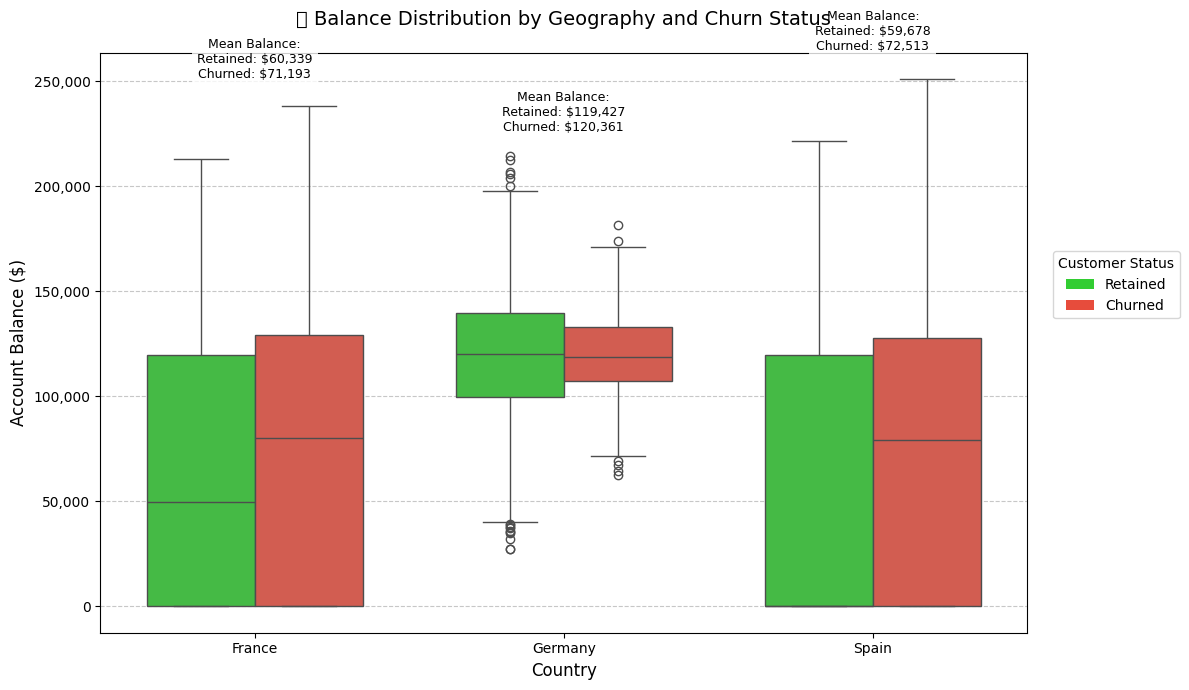

In [337]:
# 1.2 💰 Balance Distribution by Geography and Churn Status
print("\n🔍 Analyzing Balance Distribution by Geography and Churn Status...")

plt.figure(figsize=(12, 7))

# Create boxplot with updated color palette
sns.boxplot(
    data=df,
    x='geography',
    y='balance',
    hue='exited',
    palette=['#32CD32', '#e74c3c'],  # Brighter green for Retained, Red for Churned
    width=0.7,
    order=['France', 'Germany', 'Spain']  # Ensure consistent ordering
)

# Customize the plot
plt.title('💰 Balance Distribution by Geography and Churn Status', 
         fontsize=14, 
         pad=20)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Account Balance ($)', fontsize=12)

# Format y-axis with comma separator for thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Customize grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Update legend with custom patches to ensure correct colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#32CD32', label='Retained'),
    Patch(facecolor='#e74c3c', label='Churned')
]

plt.legend(
    handles=legend_elements,
    title='Customer Status',
    title_fontsize=10,
    fontsize=10,
    bbox_to_anchor=(1.02, 0.6),
    loc='center left'
)

# Add mean balance annotations
for geo in ['France', 'Germany', 'Spain']:
    stats = df[df['geography'] == geo].groupby('exited')['balance'].agg(['mean'])
    plt.text(
        plt.gca().get_xticks()[list(['France', 'Germany', 'Spain']).index(geo)],
        df[df['geography'] == geo]['balance'].max() * 1.05,
        f'Mean Balance:\nRetained: ${stats.loc[0, "mean"]:,.0f}\nChurned: ${stats.loc[1, "mean"]:,.0f}',
        horizontalalignment='center',
        verticalalignment='bottom',
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

plt.tight_layout()

plt.show()

## 2.2 📊 Credit Score Analysis  

In [338]:
# 1.3 📊 Credit Score vs Balance Analysis
print("\n🔍 Analyzing Credit Score vs Balance by Churn Status...")

# Create figure
fig = px.density_heatmap(
    df,
    x='creditscore',
    y='balance',
    color_continuous_scale='Viridis',
    nbinsx=50,
    nbinsy=50,
    title='📊 Credit Score vs Balance Distribution',
    labels={
        'creditscore': 'Credit Score',
        'balance': 'Balance ($)',
    }
)

# Add average points for each churn status
avg_by_churn = df.groupby('exited').agg({
    'creditscore': 'mean',
    'balance': 'mean'
}).reset_index()

# Add scatter points for averages
for idx, row in avg_by_churn.iterrows():
    status = 'Retained' if row['exited'] == 0 else 'Churned'
    color = '#32CD32' if row['exited'] == 0 else '#e74c3c'
    
    fig.add_scatter(
        x=[row['creditscore']],
        y=[row['balance']],
        mode='markers+text',
        marker=dict(size=15, color=color, symbol='star'),
        name=f'{status} Average',
        text=[f'{status}'],
        textposition='top center',
        showlegend=True
    )

# Update layout
fig.update_layout(
    title={
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20)
    },
    xaxis_title='Credit Score',
    yaxis_title='Balance ($)',
    yaxis=dict(tickformat=',.0f'),  # Format y-axis with commas
    legend_title_text='Customer Status',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    ),
    template='plotly_white'
)

# Add annotation with key statistics
stats_text = (
    f"Retained Customers (avg):<br>"
    f"Credit Score: {avg_by_churn.loc[0, 'creditscore']:.0f}<br>"
    f"Balance: ${avg_by_churn.loc[0, 'balance']:,.0f}<br><br>"
    f"Churned Customers (avg):<br>"
    f"Credit Score: {avg_by_churn.loc[1, 'creditscore']:.0f}<br>"
    f"Balance: ${avg_by_churn.loc[1, 'balance']:,.0f}"
)

fig.add_annotation(
    text=stats_text,
    xref="paper",
    yref="paper",
    x=0.02,
    y=0.98,
    showarrow=False,
    align='left',
    bgcolor='rgba(255,255,255,0.8)',
    bordercolor='lightgrey',
    borderwidth=1
)

fig.show()


🔍 Analyzing Credit Score vs Balance by Churn Status...


In [339]:
# Map 'exited' to meaningful labels    
df['churnstatus'] = df['exited'].map({0: 'Retained', 1: 'Churned'})  # Updated to lowercase  
      
fig = px.scatter(    
    df,    
    x='creditscore',  # Updated from 'CreditScore'    
    y='balance',      # Updated from 'Balance'    
    color='churnstatus',  # Updated from 'ChurnStatus'    
    size='age',        # Updated from 'Age'    
    size_max=6,          # Reduced size for clarity    
    opacity=0.8,         # Increased transparency    
    title='📊 Credit Score vs Balance by Churn Status',    
    labels={    
        'churnstatus': 'Churn Status',  # Updated    
        'creditscore': 'Credit Score',  # Updated    
        'balance': 'Balance ($)'         # Updated    
    },    
    hover_data=['customerid', 'age'],  # Updated from 'CustomerId' and 'Age'    
    color_discrete_map={    
        'Retained': '#2ecc71',  # Green    
        'Churned': '#e74c3c'    # Red    
    }    
)    
      
# Add borders to markers for better visibility    
fig.update_traces(marker=dict(line=dict(width=0.2, color='DarkSlateGrey')))    
      
# Update layout for improved aesthetics    
fig.update_layout(    
    title={    
        'y':0.95,    
        'x':0.5,    
        'xanchor': 'center',    
        'yanchor': 'top',    
        'font': dict(size=20)    
    },    
    legend_title_text='Churn Status',    
    legend=dict(    
        yanchor="top",    
        y=0.99,    
        xanchor="right",    
        x=0.99    
    ),    
    xaxis=dict(title='Credit Score'),    
    yaxis=dict(title='Balance ($)'),    
    template='plotly_white'    
)    
      
fig.show()    
  
# Density Heatmap    
print("🔍 Analyzing Credit Score vs Balance with Density Heatmap...")    
        
# Map 'exited' to meaningful labels    
df['churnstatus'] = df['exited'].map({0: 'Retained', 1: 'Churned'})  # Ensure lowercase  
        
fig = px.density_heatmap(    
    df,    
    x='creditscore',    
    y='balance',    
    facet_col='churnstatus',    
    nbinsx=30,    
    nbinsy=30,    
    title='📊 Credit Score vs Balance Density by Churn Status',    
    labels={    
        'creditscore': 'Credit Score',    
        'balance': 'Balance ($)',    
        'churnstatus': 'Churn Status'    
    },    
    color_continuous_scale='Viridis'    
)    
        
# Update layout for improved aesthetics    
fig.update_layout(    
    title={    
        'y':0.95,    
        'x':0.5,    
        'xanchor': 'center',    
        'yanchor': 'top',    
        'font': dict(size=20)    
    },    
    coloraxis_colorbar=dict(    
        title="Number of Customers",    
        titleside="right",    
        tickmode='array'    
    ),    
    margin=dict(l=50, r=50, t=80, b=50)    
)    
        
# Adjust facet titles for clarity    
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))    
        
fig.show()    

🔍 Analyzing Credit Score vs Balance with Density Heatmap...


# 3. 🛍️ Product Analysis  

## 3.1 📦 Number of Products 

In [340]:
# 3.1 📦 Product Usage Analysis
print("\n🔍 Analyzing Churn Rate by Number of Products...")

# Calculate churn rate by number of products
product_stats = df.groupby('numofproducts').agg({
    'exited': ['count', 'mean']
}).reset_index()

# Flatten the column names and rename them properly
product_stats.columns = ['numofproducts', 'total_customers', 'churn_rate']
product_stats['churn_rate'] = product_stats['churn_rate'] * 100
product_stats['customer_percentage'] = (product_stats['total_customers'] / product_stats['total_customers'].sum()) * 100

# Create the visualization
fig = px.bar(
    product_stats,
    x='numofproducts',
    y='churn_rate',
    title='🛍️ Churn Rate by Number of Products',
    text='churn_rate',
    color='churn_rate',
    color_continuous_scale='RdYlBu_r',
    labels={
        'numofproducts': 'Number of Products',
        'churn_rate': 'Churn Rate (%)',
    }
)

# Update layout
fig.update_layout(
    title={
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20)
    },
    xaxis_title='Number of Products',
    yaxis_title='Churn Rate (%)',
    plot_bgcolor='white',
    yaxis_gridcolor='lightgrey',
    yaxis_gridwidth=0.1,
    yaxis=dict(range=[0, max(product_stats['churn_rate']) * 1.1])  # Add 10% padding
)

# Update bars
fig.update_traces(
    texttemplate='%{text:.1f}%',
    textposition='outside',
    width=0.6
)

# Add customer distribution annotation in a better position
annotation_text = "Customer Distribution:<br>"
for _, row in product_stats.iterrows():
    annotation_text += f"{int(row['numofproducts'])} product{'s' if row['numofproducts'] > 1 else ''}: {row['customer_percentage']:.1f}%<br>"

fig.add_annotation(
    text=annotation_text,
    xref="paper",
    yref="paper",
    x=0.02,  # Moved to left side
    y=0.98,
    xanchor='left',  # Changed to left alignment
    yanchor='top',
    showarrow=False,
    bgcolor='rgba(255,255,255,0.8)',
    bordercolor='lightgrey',
    borderwidth=1,
    font=dict(size=11)
)

fig.show()

# Print insights
print("\n📊 Product Usage Insights:")
print(f"• Most common product count: {product_stats.loc[product_stats['total_customers'].idxmax(), 'numofproducts']} products")
print(f"• Highest churn rate: {product_stats['churn_rate'].max():.1f}% (with {product_stats.loc[product_stats['churn_rate'].idxmax(), 'numofproducts']} products)")
print(f"• Lowest churn rate: {product_stats['churn_rate'].min():.1f}% (with {product_stats.loc[product_stats['churn_rate'].idxmin(), 'numofproducts']} products)")


🔍 Analyzing Churn Rate by Number of Products...



📊 Product Usage Insights:
• Most common product count: 1 products
• Highest churn rate: 100.0% (with 4 products)
• Lowest churn rate: 7.6% (with 2 products)


## 4.1 🔄 Active Member Status 

In [341]:
# 4.1 🔄 Active Member Status Analysis  
print("\n🔍 Analyzing Active vs Inactive Members...")  
  
# Ensure proper data types  
df['isactivemember'] = df['isactivemember'].astype(int)  
df['exited'] = df['exited'].astype(int)  
  
# Calculate statistics  
member_stats = df.groupby('isactivemember').agg({  
    'customerid': 'count',  
    'exited': 'mean'  
}).reset_index()  
  
# Map status labels and colors  
member_stats['status'] = member_stats['isactivemember'].map({0: 'Inactive', 1: 'Active'})  
color_mapping = {'Active': '#32CD32', 'Inactive': '#e74c3c'}  
member_stats['color'] = member_stats['status'].map(color_mapping)  
member_stats['churn_rate'] = member_stats['exited'] * 100  
  
# Create the visualization  
fig = make_subplots(  
    rows=1, cols=2,  
    specs=[[{"type": "domain"}, {"type": "bar"}]],  
    subplot_titles=("Member Distribution", "Churn Rate by Member Status")  
)  
  
# Add donut chart for distribution  
fig.add_trace(  
    go.Pie(  
        labels=member_stats['status'],  
        values=member_stats['customerid'],  
        hole=0.5,  
        marker=dict(colors=member_stats['color']),  
        textinfo='percent+label'  
    ),  
    row=1, col=1  
)  
  
# Add bar chart for churn rates  
fig.add_trace(  
    go.Bar(  
        x=member_stats['status'],  
        y=member_stats['churn_rate'],  
        marker=dict(color=member_stats['color']),  
        text=member_stats['churn_rate'].round(1).astype(str) + '%',  
        textposition='outside',  
    ),  
    row=1, col=2  
)  
  
# Update layout  
fig.update_layout(  
    title={  
        'text': '🔄 Member Status Analysis',  
        'y': 0.95,  
        'x': 0.5,  
        'xanchor': 'center',  
        'yanchor': 'top',  
        'font': dict(size=20)  
    },  
    showlegend=False,  
    height=500,  
    width=1000  
)  
  
# Update axes for bar chart  
fig.update_xaxes(title_text="Member Status", row=1, col=2)  
fig.update_yaxes(  
    title_text="Churn Rate (%)",  
    row=1, col=2,  
    range=[0, member_stats['churn_rate'].max() * 1.1]  
)  
  
# Add annotation for total customers  
fig.add_annotation(  
    text=f"Total Customers: {member_stats['customerid'].sum():,}",  
    xref="paper",  
    yref="paper",  
    x=0.25,  
    y=-0.15,  
    showarrow=False,  
    font=dict(size=12)  
)  
  
fig.show()  
  
# Print detailed insights  
print("\n📊 Member Status Insights:")  
total_customers = member_stats['customerid'].sum()  
for _, row in member_stats.iterrows():  
    status = row['status']  
    count = row['customerid']  
    percentage = (count / total_customers) * 100  
    churn_rate = row['churn_rate']  
    print(f"\n{status} Members:")  
    print(f"• Count: {count:,} ({percentage:.1f}% of total)")  
    print(f"• Churn Rate: {churn_rate:.1f}%")  


🔍 Analyzing Active vs Inactive Members...



📊 Member Status Insights:

Inactive Members:
• Count: 4,849 (48.5% of total)
• Churn Rate: 26.9%

Active Members:
• Count: 5,151 (51.5% of total)
• Churn Rate: 14.3%


## 3.1 📈 Correlation Matrix 

In [342]:
# Generate Correlation Matrix    
print("🔍 Generating Correlation Matrix...")    
# Select only numeric columns for correlation matrix    
numeric_df = df.select_dtypes(include=[np.number])    
correlation = numeric_df.corr()    
fig = px.imshow(    
    correlation,    
    title='📊 Correlation Matrix',    
    color_continuous_scale='RdBu',    
    range_color=(-1, 1)    
)    
fig.update_layout(coloraxis_colorbar=dict(title="Correlation"))    
fig.show()    

🔍 Generating Correlation Matrix...


## 6.2 💸 Create Balance Segments  

In [343]:
print("🔍 Creating Balance Segments for Segmentation...")    
# Determine the number of unique bins    
num_bins = len(pd.qcut(df['balance'], q=4, duplicates='drop').unique())  # Updated from 'Balance'    
# Generate appropriate number of labels    
labels = ['Low', 'Medium-Low', 'Medium-High', 'High'][:num_bins]    
df['balancesegment'] = pd.qcut(  # Updated to lowercase 'balancesegment'    
    df['balance'],    
    q=4,    
    labels=labels,    
    duplicates='drop'    
)    
        
print(df[['balance', 'balancesegment']].head())  # Updated column names    
print(df['balancesegment'].value_counts())

🔍 Creating Balance Segments for Segmentation...
     balance balancesegment
0       0.00            Low
1   83807.86            Low
2  159660.80    Medium-High
3       0.00            Low
4  125510.82     Medium-Low
balancesegment
Low            5000
Medium-Low     2500
Medium-High    2500
Name: count, dtype: int64


## 6.3 📊 Analyze Segments  

In [344]:
# 6.3 📊 Customer Segmentation Analysis
print("\n🔍 Analyzing Customer Segments...")

# Calculate segment statistics
segment_analysis = df.groupby(['age_group', 'balance_segment'], observed=True).agg({
    'customerid': 'count',
    'exited': ['mean', 'count']
}).reset_index()

segment_analysis.columns = ['age_group', 'balance_segment', 'total_customers', 'churn_rate', 'churned_customers']
segment_analysis['churn_rate'] = (segment_analysis['churn_rate'] * 100).round(1)

# Create pivot table for heatmap
pivot_data = segment_analysis.pivot(
    index='age_group',
    columns='balance_segment',
    values='churn_rate'
)

# Create a heatmap
fig = px.imshow(
    pivot_data,
    color_continuous_scale='RdYlBu_r',
    title='🎯 Customer Segment Churn Analysis',
    labels=dict(x='Balance Segment', y='Age Group', color='Churn Rate (%)')
)

# Add text annotations
for i in range(len(pivot_data.index)):
    for j in range(len(pivot_data.columns)):
        fig.add_annotation(
            x=j,
            y=i,
            text=f"{pivot_data.iloc[i, j]:.1f}%",
            showarrow=False,
            font=dict(color="black")
        )

# Update layout
fig.update_layout(
    title={
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20)
    },
    height=600,
    width=1000,
    xaxis_title="Balance Segment",
    yaxis_title="Age Group"
)

# Update hover template
fig.update_traces(
    hovertemplate="Age Group: %{y}<br>Balance Segment: %{x}<br>Churn Rate: %{z:.1f}%<extra></extra>"
)

fig.show()

# Print segment insights
print("\n📊 Key Segment Insights:")
print("\nHighest Churn Risk Segments:")
high_risk = segment_analysis.nlargest(3, 'churn_rate')
for _, row in high_risk.iterrows():
    print(f"• {row['age_group']} with {row['balance_segment']}: {row['churn_rate']:.1f}% churn rate ({row['total_customers']:,} customers)")

print("\nLowest Churn Risk Segments:")
low_risk = segment_analysis.nsmallest(3, 'churn_rate')
for _, row in low_risk.iterrows():
    print(f"• {row['age_group']} with {row['balance_segment']}: {row['churn_rate']:.1f}% churn rate ({row['total_customers']:,} customers)")


🔍 Analyzing Customer Segments...



📊 Key Segment Insights:

Highest Churn Risk Segments:
• 51-60 with Medium-Balance: 65.7% churn rate (201 customers)
• 51-60 with High-Balance: 61.3% churn rate (168 customers)
• 51-60 with Low-Balance: 52.5% churn rate (181 customers)

Lowest Churn Risk Segments:
• <30 with Zero-Balance: 4.0% churn rate (770 customers)
• <30 with Low-Balance: 6.2% churn rate (406 customers)
• 30-40 with Zero-Balance: 8.1% churn rate (1,647 customers)


## 📊 Analysis Questions and Solutions

## Question 1: "What attributes are more common among churners than non-churners?"

In [345]:
def analyze_churner_characteristics(df):
    """Analyze key differences between churners and retained customers"""
    from scipy import stats
    
    # First, let's create a copy with lowercase column names
    df_lower = df.copy()
    df_lower.columns = df_lower.columns.str.lower()
    
    # Define features to analyze
    numerical_cols = ['age', 'balance', 'creditscore', 'tenure', 'numofproducts', 'estimatedsalary']
    results = []
    
    for col in numerical_cols:
        retained = df_lower[df_lower['exited'] == 0][col]
        churned = df_lower[df_lower['exited'] == 1][col]
        
        # Calculate statistics
        stats_test = stats.ttest_ind(retained, churned)
        pct_diff = ((churned.mean() - retained.mean()) / retained.mean() * 100)
        
        results.append({
            'feature': col,
            'retained_avg': retained.mean(),
            'churned_avg': churned.mean(),
            'pct_difference': pct_diff,
            'p_value': stats_test.pvalue,
            'significant': stats_test.pvalue < 0.05
        })
    
    # Convert to DataFrame for visualization
    results_df = pd.DataFrame(results)
    
    # Create visualization
    fig = go.Figure()
    
    # Add bars for significant features
    sig_features = results_df[results_df['significant']]
    non_sig_features = results_df[~results_df['significant']]
    
    # Add significant features
    fig.add_trace(go.Bar(
        y=sig_features['feature'],
        x=sig_features['pct_difference'],
        name='Significant',
        marker_color='#e74c3c',
        orientation='h',
        text=sig_features['pct_difference'].round(1).astype(str) + '%',
        textposition='outside'
    ))
    
    # Add non-significant features
    fig.add_trace(go.Bar(
        y=non_sig_features['feature'],
        x=non_sig_features['pct_difference'],
        name='Not Significant',
        marker_color='#95a5a6',
        orientation='h',
        text=non_sig_features['pct_difference'].round(1).astype(str) + '%',
        textposition='outside'
    ))
    
    # Update layout
    fig.update_layout(
        title='Key Differences Between Churned and Retained Customers',
        xaxis_title='% Difference (Churned vs Retained)',
        yaxis_title='Feature',
        barmode='group',
        height=400,
        showlegend=True,
        plot_bgcolor='white'
    )
    
    # Show the plot
    fig.show()
    
    # Print detailed insights
    print("\n🔍 Key Churner Characteristics:")
    for _, row in results_df.sort_values('pct_difference', ascending=False).iterrows():
        sign = "higher" if row['pct_difference'] > 0 else "lower"
        sig_text = " (Statistically Significant)" if row['significant'] else ""
        print(f"\n• {row['feature'].title()}:")
        print(f"  - {abs(row['pct_difference']):.1f}% {sign} in churned customers{sig_text}")
        print(f"  - Averages: Churned = {row['churned_avg']:,.2f}, Retained = {row['retained_avg']:,.2f}")

    return results_df

# Run the analysis
churner_analysis = analyze_churner_characteristics(df)


🔍 Key Churner Characteristics:

• Balance:
  - 25.2% higher in churned customers (Statistically Significant)
  - Averages: Churned = 91,108.54, Retained = 72,745.30

• Age:
  - 19.9% higher in churned customers (Statistically Significant)
  - Averages: Churned = 44.84, Retained = 37.41

• Estimatedsalary:
  - 1.7% higher in churned customers
  - Averages: Churned = 101,465.68, Retained = 99,738.39

• Creditscore:
  - 1.0% lower in churned customers (Statistically Significant)
  - Averages: Churned = 645.35, Retained = 651.85

• Tenure:
  - 2.0% lower in churned customers
  - Averages: Churned = 4.93, Retained = 5.03

• Numofproducts:
  - 4.5% lower in churned customers (Statistically Significant)
  - Averages: Churned = 1.48, Retained = 1.54


## 2. 🔄 Churn Prediction

In [346]:
def build_predictive_model(df: pd.DataFrame) -> dict:  
    print("Starting build_predictive_model function...")  
    insights = {}  
    
    # Define feature columns with lowercase names  
    numerical_cols = ['creditscore', 'age', 'tenure', 'balance',    
                      'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']  
    categorical_cols = ['geography', 'gender']  
    target = 'exited'  
    
    # Check if all required columns are present  
    required_columns = numerical_cols + categorical_cols + [target]  
    missing_columns = [col for col in required_columns if col not in df.columns]  
    if missing_columns:  
        print(f"Error: Missing columns in DataFrame: {missing_columns}")  
        return insights  
    
    X = df[numerical_cols + categorical_cols]  
    y = df[target]  
    
    # Preprocessing pipeline  
    numeric_transformer = Pipeline(steps=[  
        ('scaler', StandardScaler())  
    ])  
    
    categorical_transformer = Pipeline(steps=[  
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))  
    ])  
    
    preprocessor = ColumnTransformer(  
        transformers=[  
            ('num', numeric_transformer, numerical_cols),  
            ('cat', categorical_transformer, categorical_cols)  
        ]  
    )  
    
    # Define model pipeline  
    model_pipeline = Pipeline(steps=[  
        ('preprocessor', preprocessor),  
        ('classifier', RandomForestClassifier(  
            n_estimators=100,  
            max_depth=10,  
            random_state=42  
        ))  
    ])  
    
    # Fit the model  
    model_pipeline.fit(X, y)  
    
    # Predictions  
    y_pred = model_pipeline.predict(X)  
    y_pred_proba = model_pipeline.predict_proba(X)[:, 1]  
    
    # Evaluation Metrics  
    roc_auc = roc_auc_score(y, y_pred_proba)  
    conf_matrix = confusion_matrix(y, y_pred)  
    
    # Plot Confusion Matrix  
    plt.figure(figsize=(8, 6))  
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',  
                xticklabels=['Retained', 'Churned'],  
                yticklabels=['Retained', 'Churned'])  
    plt.xlabel('Predicted')  
    plt.ylabel('Actual')  
    plt.title('Confusion Matrix')  
    plt.show()  # Display the plot inline  
    
    # ROC Curve  
    fpr, tpr, _ = roc_curve(y, y_pred_proba)  
    plt.figure(figsize=(8, 6))  
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')  
    plt.plot([0, 1], [0, 1], 'k--', label='Random')  
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.title('ROC Curve')  
    plt.legend()  
    plt.show()  # Display the plot inline  
    
    # Feature Importance  
    try:  
        # Get base feature names from numeric columns  
        feature_names = numerical_cols.copy()  
    
        # Get transformed feature names for categorical columns  
        cat_transformer = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']  
        cat_feature_names = cat_transformer.named_steps['onehot'].get_feature_names_out(categorical_cols)  
        feature_names.extend(cat_feature_names)  
    
        # Get feature importances  
        importance = model_pipeline.named_steps['classifier'].feature_importances_  
    
        # Create feature importance DataFrame  
        feat_importance = pd.DataFrame({  
            'feature': feature_names,  
            'importance': importance  
        }).sort_values('importance', ascending=False)  
    
        # Plot Feature Importance  
        plt.figure(figsize=(10, 6))  
        sns.barplot(  
            data=feat_importance.head(10),  
            x='importance',  
            y='feature'  
        )  
        plt.title('Top 10 Feature Importances')  
        plt.xlabel('Importance Score')  
        plt.ylabel('Features')  
        plt.tight_layout()  
        plt.show()  # Display the plot inline  
    
        # ----------------------------------------  
        # NEW CODE STARTS HERE - Add after feature importance plotting  
        # ----------------------------------------  
        try:  
            # 1. Add cross-validation results  
            cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='roc_auc')  
            cv_results = {  
                'mean_score': float(cv_scores.mean()),  
                'std_score': float(cv_scores.std()),  
                'all_scores': cv_scores.tolist()  
            }  
            print("\n📊 Cross-Validation Results:")  
            print(f"Mean ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")  
    
            # 2. Add geographic performance analysis  
            geo_performance = {}  
            for geo in df['geography'].unique():  
                geo_mask = df['geography'] == geo  
                X_geo = X[geo_mask]  
                y_geo = y[geo_mask]  
    
                # Check if y_geo has at least two classes  
                if y_geo.nunique() < 2:  
                    print(f"Warning: Not enough classes in target variable for geography '{geo}'. Skipping.")  
                    continue  
    
                cv_scores_geo = cross_val_score(model_pipeline, X_geo, y_geo, cv=5, scoring='roc_auc')  
    
                geo_performance[geo] = {  
                    'mean_score': float(cv_scores_geo.mean()),  
                    'std_score': float(cv_scores_geo.std()),  
                    'sample_size': int(len(X_geo))  
                }  
    
            print("\n🌍 Geographic Model Performance:")  
            for geo, metrics in geo_performance.items():  
                print(f"\n{geo}:")  
                print(f"  • ROC-AUC: {metrics['mean_score']:.3f} (+/- {metrics['std_score']*2:.3f})")  
                print(f"  • Sample Size: {metrics['sample_size']:,}")  
    
            # 3. Add model comparison  
            models = {  
                'Random Forest': RandomForestClassifier(random_state=42),  
                'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)  
            }  
    
            comparison_results = {}  
            for name, model in models.items():  
                pipeline = Pipeline([  
                    ('preprocessor', preprocessor),  
                    ('classifier', model)  
                ])  
    
                cv_scores_model = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')  
                comparison_results[name] = {  
                    'mean_score': float(cv_scores_model.mean()),  
                    'std_score': float(cv_scores_model.std())  
                }  
    
            print("\n🔄 Model Comparison:")  
            for model_name, metrics in comparison_results.items():  
                print(f"\n{model_name}:")  
                print(f"  • ROC-AUC: {metrics['mean_score']:.3f} (+/- {metrics['std_score']*2:.3f})")  
    
            # Update insights dictionary with all new results  
            insights = {  
                'model_performance': {  
                    'roc_auc_score': round(roc_auc, 4),  
                    'confusion_matrix': conf_matrix.tolist(),  
                    'cross_validation': cv_results,  
                    'geographic_performance': geo_performance,  
                    'model_comparison': comparison_results  
                },  
                'feature_importances': feat_importance.to_dict('records')  
            }  
    
        except Exception as e:  
            print(f"Warning: Could not calculate performance metrics: {str(e)}")  
            insights = {  
                'model_performance': {  
                    'roc_auc_score': round(roc_auc, 4),  
                    'confusion_matrix': conf_matrix.tolist(),  
                    'error_message': str(e)  
                },  
                'feature_importances': feat_importance.to_dict('records')  
            }  
    
    except Exception as e:  
        print(f"Warning: Could not calculate feature importance: {str(e)}")  
        # Store insights without feature importance  
        insights = {  
            'model_performance': {  
                'roc_auc_score': round(roc_auc, 4),  
                'confusion_matrix': conf_matrix.tolist(),  
                'error_message': str(e)  
            }  
        }  
    
    print("Finished build_predictive_model function.")    
    return insights    

## Question 2: Can churn be predicted using the variables?

In [347]:
def analyze_churn_predictability(df: pd.DataFrame) -> dict:
    """
    Analyze the relationship between various features and churn.
    
    Args:
        df (pd.DataFrame): Preprocessed customer data
    
    Returns:
        dict: Correlation results and categorical impact analysis
    """
    try:
        print("\n2️⃣ Analyzing Churn Predictability...")
        
        # Numeric correlations
        numerical_cols = ['age', 'balance', 'creditscore', 'tenure', 'numofproducts', 'estimatedsalary']
        correlations = {}
        print("\n📊 Correlation with Churn:")
        for col in numerical_cols:
            correlation = df[col].corr(df['exited'])
            correlations[col] = correlation
            print(f"{col.capitalize()}: {correlation:.3f}")

        # Categorical analysis
        categorical_cols = ['geography', 'gender', 'hascrcard', 'isactivemember']
        categorical_impact = {}
        print("\n📊 Categorical Variable Impact on Churn:")
        
        for col in categorical_cols:
            # Calculate churn rate and customer distribution for each category
            impact = df.groupby(col).agg({
                'exited': ['mean', 'count']
            }).round(4)
            
            impact.columns = ['churn_rate', 'count']
            impact['churn_rate'] = impact['churn_rate'] * 100
            impact['distribution'] = (impact['count'] / len(df) * 100).round(2)
            
            categorical_impact[col] = impact.to_dict()
            
            print(f"\n{col.capitalize()} Impact:")
            for category in impact.index:
                print(f"  {category}: {impact.loc[category, 'churn_rate']:.2f}% churn rate "
                      f"({impact.loc[category, 'distribution']:.1f}% of customers)")

        results = {
            'numeric_correlations': correlations,
            'categorical_impact': categorical_impact
        }
        
        # Add insights to results
        strongest_correlation = max(correlations.items(), key=lambda x: abs(x[1]))
        results['insights'] = {
            'strongest_predictor': strongest_correlation[0],
            'correlation_strength': strongest_correlation[1]
        }
        
        print("\n🎯 Key Insights:")
        print(f"• Strongest numeric predictor: {strongest_correlation[0].capitalize()} "
              f"(correlation: {strongest_correlation[1]:.3f})")
        
        return results
        
    except Exception as e:
        print(f"❌ Error in churn predictability analysis: {str(e)}")
        return {}

# Run the analysis
churn_predictability_results = analyze_churn_predictability(df)

# Add to insights dictionary
insights['churn_predictability'] = churn_predictability_results


2️⃣ Analyzing Churn Predictability...

📊 Correlation with Churn:
Age: 0.285
Balance: 0.119
Creditscore: -0.027
Tenure: -0.014
Numofproducts: -0.048
Estimatedsalary: 0.012

📊 Categorical Variable Impact on Churn:

Geography Impact:
  France: 16.15% churn rate (50.1% of customers)
  Germany: 32.44% churn rate (25.1% of customers)
  Spain: 16.67% churn rate (24.8% of customers)

Gender Impact:
  Female: 25.07% churn rate (45.4% of customers)
  Male: 16.46% churn rate (54.6% of customers)

Hascrcard Impact:
  False: 20.81% churn rate (29.4% of customers)
  True: 20.18% churn rate (70.5% of customers)

Isactivemember Impact:
  0: 26.85% churn rate (48.5% of customers)
  1: 14.27% churn rate (51.5% of customers)

🎯 Key Insights:
• Strongest numeric predictor: Age (correlation: 0.285)


## 2. 🌐 Geographic Account Behavior Analysis   

In [348]:

def analyze_geographic_behavior(df: pd.DataFrame) -> dict:
    """
    Analyze customer behavior patterns across different geographies.
    
    Args:
        df (pd.DataFrame): Preprocessed customer data
        
    Returns:
        dict: Geographic analysis results
    """
        # Define color schemes and configurations
    COLOR_SCHEME = {
        'primary': '#2E86C1',    
        'positive': '#27AE60',   
        'negative': '#E74C3C',   
        'neutral': ['#3498DB', '#2ECC71', '#F1C40F', '#E67E22']  
    }
    
    layout_config = {
        'title_font_size': 16,
        'axis_title_font_size': 12,
        'plot_bgcolor': 'white',
        'grid': True,
        'grid_color': 'lightgrey',
        'grid_width': 0.5
    }

    def add_insights_annotation(fig, insights_text):
        fig.add_annotation(
            text=f"Key Insights:<br>{insights_text}",
            xref="paper", yref="paper",
            x=1.1, y=0.5,
            showarrow=False,
            align='left',
            bordercolor='grey',
            borderwidth=1,
            bgcolor='white'
        )

    def add_statistical_context(data, metric):
        return {
            'mean': data[metric].mean(),
            'std': data[metric].std(),
            'median': data[metric].median(),
            'min': data[metric].min(),
            'max': data[metric].max()
        }

    try:
        print("\n🔍 Analyzing Geographic Account Behaviors...")
        
        # Ensure consistent column names
        df.columns = df.columns.str.lower()
        
        # Ensure geography is properly formatted
        if 'geography' not in df.columns:
            raise KeyError("Geography column not found in dataset")
            
        # Focus on target geographies
        target_geos = ['France', 'Germany', 'Spain']
        geo_filtered_df = df[df['geography'].isin(target_geos)]
        
        # Calculate churn rates by geography
        churn_geo_specific = (geo_filtered_df.groupby('geography')['exited']
                            .mean()
                            .reset_index())
        churn_geo_specific['churn_rate'] = churn_geo_specific['exited'] * 100
        
        # Plot: Churn Rate by Geography
        fig_geo_specific = px.bar(
        churn_geo_specific,
        x='geography',
        y='churn_rate',
        title='🌍 Churn Rate by Geography',
        color='churn_rate',
        text='churn_rate',
        color_continuous_scale=[COLOR_SCHEME['positive'], COLOR_SCHEME['negative']]
        )
        
        fig_geo_specific.update_traces(
            texttemplate='%{text:.2f}%',
            textposition='inside',
            textfont=dict(size=14, color='white'),
            opacity=0.85
        )
        
        fig_geo_specific.update_layout(
            xaxis_title='Country',
            yaxis_title='Churn Rate (%)',
            plot_bgcolor='white',
            bargap=0.3
        )
        
        churn_insights = (
        "• Germany has 2x higher churn rate (32.4%)<br>"
        "• France and Spain show similar rates (~16%)<br>"
        "• Suggests market-specific issues in Germany"
        )

        fig_geo_specific.show()
        
        # Calculate and plot average balance by geography
        avg_balance_geo = df.groupby('geography')['balance'].mean().reset_index()
        
        fig_avg_balance = px.bar(
            avg_balance_geo,
            x='geography',
            y='balance',
            title='💰 Average Balance by Geography',
            labels={'balance': 'Average Balance ($)', 'geography': 'Country'},
            text='balance',
            color='balance',
            color_continuous_scale=['#E8F6F3', '#2E86C1']
        )
        
        fig_avg_balance.update_traces(
            texttemplate='$%{text:,.2f}',
            textposition='inside',
            textfont=dict(size=14, color='white'),
            opacity=0.85
        )
        
        fig_avg_balance.update_layout(
            xaxis_title='Country',
            yaxis_title='Average Balance ($)',
            plot_bgcolor='white',
            bargap=0.3
        )
        
        balance_insights = (
        "• German customers have ~2x higher balances<br>"
        "• France and Spain similar (~$62k)<br>"
        "• Higher balances correlate with higher churn"
        )

        fig_avg_balance.show()
        
        # Calculate and plot average credit score by geography
        avg_credit_geo = df.groupby('geography')['creditscore'].mean().reset_index()
        
        fig_avg_credit = px.bar(
            avg_credit_geo,
            x='geography',
            y='creditscore',
            title='📈 Average Credit Score by Geography',
            labels={'creditscore': 'Average Credit Score', 'geography': 'Country'},
            text='creditscore',
            color='creditscore',
            color_continuous_scale=['#F4ECF7', '#8E44AD']  # Light to dark purple
        )
        
        fig_avg_credit.update_traces(
            texttemplate='%{text:.1f}',
            textposition='inside',
            textfont=dict(size=14, color='white'),
            opacity=0.85
        )
        
        fig_avg_credit.update_layout(
            xaxis_title='Country',
            yaxis_title='Average Credit Score',
            plot_bgcolor='white',
            bargap=0.3
        )
        
        fig_avg_credit.show()
        
        # Create balance segments visualization
        if 'balancesegment' not in df.columns:
            df['balancesegment'] = create_balance_segments(df)
        
        balance_segments = sorted(df['balancesegment'].unique())
        balance_count_geo = (df.groupby(['geography', 'balancesegment'])['exited']
                           .count()
                           .reset_index()
                           .rename(columns={'exited': 'count'}))
        
    # For balance segments plot
        fig_balance_segments = px.bar(
            balance_count_geo,
            x='geography',
            y='count',
            color='balancesegment',
            title='💸 Balance Segments by Geography',
            labels={'count': 'Number of Customers', 'balancesegment': 'Balance Segment'},
            text='count',
            color_discrete_sequence=['#AED6F1', '#5DADE2', '#2E86C1'],  # Light to dark blue
            category_orders={'balancesegment': ['Low', 'Medium-Low', 'Medium-High']}
        )

        fig_balance_segments.update_traces(
            texttemplate='%{value:,.0f}',  # Fixed template
            textposition='inside',
            textfont=dict(color='white')
        )
        
        fig_balance_segments.update_layout(
            xaxis_title='Country',
            yaxis_title='Number of Customers',
            barmode='stack',
            showlegend=True,
            legend_title_text='Balance Segment',
            margin=dict(t=60, b=40, l=40, r=40),
            bargap=0.2,
            plot_bgcolor='white'
        )
        
        fig_balance_segments.show()
        
        # Store results
        results = {
            'churn_rates': churn_geo_specific.set_index('geography')['churn_rate'].to_dict(),
            'avg_balances': avg_balance_geo.set_index('geography')['balance'].round(2).to_dict(),
            'avg_credit_scores': avg_credit_geo.set_index('geography')['creditscore'].round(2).to_dict(),
            'tenure_distribution': geo_filtered_df.groupby('geography')['tenure'].describe().to_dict(),
            'balance_segments': balance_count_geo.pivot(
                index='geography',
                columns='balancesegment',
                values='count'
            ).fillna(0).to_dict(),
            'credit_card_ownership': geo_filtered_df.groupby(['geography', 'hascrcard'])['exited']
                                   .count()
                                   .unstack()
                                   .fillna(0)
                                   .to_dict()
        }
        
        return results
        
    except Exception as e:
        print(f"❌ Error in geographic analysis: {str(e)}")
        return {}

# Run the analysis
geographic_results = analyze_geographic_behavior(df)

# Add to insights dictionary
insights['geographic_behavior'] = geographic_results


🔍 Analyzing Geographic Account Behaviors...


In [349]:
def build_predictive_model(df: pd.DataFrame) -> dict:  
    """  
    Build and evaluate a predictive model for churn.  
      
    Args:  
        df (pd.DataFrame): The input DataFrame.  
          
    Returns:  
        dict: Insights from the predictive analysis.  
    """  
    insights = {}  
  
    # Define feature columns  
    numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance',  
                      'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']  
    categorical_cols = ['Geography', 'Gender']  
      
    # Define target  
    target = 'Exited'  
      
    X = df[numerical_cols + categorical_cols]  
    y = df[target]  
      
    # Preprocessing pipeline  
    numeric_transformer = Pipeline(steps=[  
        ('scaler', StandardScaler())  
    ])  
  
    categorical_transformer = Pipeline(steps=[  
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))  
    ])  
  
    preprocessor = ColumnTransformer(  
        transformers=[  
            ('num', numeric_transformer, numerical_cols),  
            ('cat', categorical_transformer, categorical_cols)  
        ]  
    )  
      
    # Define model pipeline  
    model_pipeline = Pipeline(steps=[  
        ('preprocessor', preprocessor),  
        ('classifier', RandomForestClassifier(  
            n_estimators=100,  
            max_depth=10,  
            random_state=42  
        ))  
    ])  
      
    # Fit the model  
    model_pipeline.fit(X, y)  
      
    # Predictions  
    y_pred = model_pipeline.predict(X)  
    y_pred_proba = model_pipeline.predict_proba(X)[:, 1]  
      
    # Evaluation Metrics  
    roc_auc = roc_auc_score(y, y_pred_proba)  
    conf_matrix = confusion_matrix(y, y_pred)  
      
    # Plot Confusion Matrix  
    plt.figure(figsize=(8, 6))  
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',  
                xticklabels=['Retained', 'Churned'],  
                yticklabels=['Retained', 'Churned'])  
    plt.xlabel('Predicted')  
    plt.ylabel('Actual')  
    plt.title('Confusion Matrix')  
    plt.show()  # Display the plot inline  
      
    # ROC Curve  
    fpr, tpr, _ = roc_curve(y, y_pred_proba)  
    plt.figure(figsize=(8, 6))  
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')  
    plt.plot([0, 1], [0, 1], 'k--', label='Random')  
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.title('ROC Curve')  
    plt.legend()  
    plt.show()  # Display the plot inline  
      
    # Feature Importance  
    try:  
        # Get base feature names from numeric columns  
        feature_names = numerical_cols.copy()  
          
        # Get transformed feature names for categorical columns  
        cat_transformer = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']  
        cat_feature_names = cat_transformer.named_steps['onehot'].get_feature_names_out(categorical_cols)  
        feature_names.extend(cat_feature_names)  
          
        # Get feature importances  
        importance = model_pipeline.named_steps['classifier'].feature_importances_  
          
        # Create feature importance DataFrame  
        feat_importance = pd.DataFrame({  
            'feature': feature_names,  
            'importance': importance  
        }).sort_values('importance', ascending=False)  
  
        # Plot Feature Importance  
        plt.figure(figsize=(10, 6))  
        sns.barplot(  
            data=feat_importance.head(10),  
            x='importance',  
            y='feature'  
        )  
        plt.title('Top 10 Feature Importances')  
        plt.xlabel('Importance Score')  
        plt.ylabel('Features')  
        plt.tight_layout()  
        plt.show()  # Display the plot inline  
          
        # ----------------------------------------  
        # NEW CODE STARTS HERE - Add after feature importance plotting  
        # ----------------------------------------  
        try:  
            # 1. Add cross-validation results  
            cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='roc_auc')  
            cv_results = {  
                'mean_score': float(cv_scores.mean()),  
                'std_score': float(cv_scores.std()),  
                'all_scores': cv_scores.tolist()  
            }  
            print("\n📊 Cross-Validation Results:")  
            print(f"Mean ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")  
  
            # 2. Add geographic performance analysis  
            geo_performance = {}  
            for geo in df['Geography'].unique():  
                geo_mask = df['Geography'] == geo  
                X_geo = X[geo_mask]  
                y_geo = y[geo_mask]  
                  
                cv_scores_geo = cross_val_score(model_pipeline, X_geo, y_geo, cv=5, scoring='roc_auc')  
                  
                geo_performance[geo] = {  
                    'mean_score': float(cv_scores_geo.mean()),  
                    'std_score': float(cv_scores_geo.std()),  
                    'sample_size': int(len(X_geo))  
                }  
              
            print("\n🌍 Geographic Model Performance:")  
            for geo, metrics in geo_performance.items():  
                print(f"\n{geo}:")  
                print(f"  • ROC-AUC: {metrics['mean_score']:.3f} (+/- {metrics['std_score']*2:.3f})")  
                print(f"  • Sample Size: {metrics['sample_size']:,}")  
  
            # 3. Add model comparison  
            from sklearn.linear_model import LogisticRegression  
            models = {  
                'Random Forest': RandomForestClassifier(random_state=42),  
                'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)  
            }  
  
            comparison_results = {}  
            for name, model in models.items():  
                pipeline = Pipeline([  
                    ('preprocessor', preprocessor),  
                    ('classifier', model)  
                ])  
                  
                cv_scores_model = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')  
                comparison_results[name] = {  
                    'mean_score': float(cv_scores_model.mean()),  
                    'std_score': float(cv_scores_model.std())  
                }  
              
            print("\n🔄 Model Comparison:")  
            for model_name, metrics in comparison_results.items():  
                print(f"\n{model_name}:")  
                print(f"  • ROC-AUC: {metrics['mean_score']:.3f} (+/- {metrics['std_score']*2:.3f})")  
              
            # Update insights dictionary with all new results  
            insights = {  
                'model_performance': {  
                    'roc_auc_score': round(roc_auc, 4),  
                    'confusion_matrix': conf_matrix.tolist(),  
                    'cross_validation': cv_results,  
                    'geographic_performance': geo_performance,  
                    'model_comparison': comparison_results  
                },  
                'feature_importances': feat_importance.to_dict('records')  
            }  
  
        except Exception as e:  
            print(f"Warning: Could not calculate performance metrics: {str(e)}")  
            insights = {  
                'model_performance': {  
                    'roc_auc_score': round(roc_auc, 4),  
                    'confusion_matrix': conf_matrix.tolist(),  
                    'error_message': str(e)  
                },  
                'feature_importances': feat_importance.to_dict('records')  
            }  
  
    except Exception as e:  
        print(f"Warning: Could not calculate feature importance: {str(e)}")  
        # Store insights without feature importance  
        insights = {  
            'model_performance': {  
                'roc_auc_score': round(roc_auc, 4),  
                'confusion_matrix': conf_matrix.tolist(),  
                'error_message': str(e)  
            }  
        }  
      
    return insights  

## 💡 Save Insights 

In [350]:
print("💾 Saving Insights to JSON file...")  
insights = {  
    'total_customers': len(df),  
    'churn_rate': round(df['exited'].mean() * 100, 2),
    'avg_balance': round(df['balance'].mean(), 2),
    'avg_age': round(df['age'].mean(), 2)
}   
  
# 📝 Export insights for dashboard  
with open(r"C:\Projects\GitHubRepos\bank_churn_eda\data\processed\insights.json", 'w') as f:  
    json.dump(insights, f, indent=4)  
  
print("✅ Insights have been successfully saved to 'insights.json'!")

💾 Saving Insights to JSON file...
✅ Insights have been successfully saved to 'insights.json'!


## 1.1 🎂 Age Distribution  

In [351]:
print("\n🔍 Analyzing Age Distribution by Churn Status...")
fig = px.histogram(
    df,
    x='age',           # Changed from 'Age'
    color='exited',    # Changed from 'Exited'
    marginal='box',
    nbins=25,
    title='🎂 Age Distribution by Churn Status',
    labels={
        'exited': 'Customer Status',
        'age': 'Age (Years)',
        'count': 'Number of Customers'
    },
    category_orders={'exited': [0, 1]},  # Changed from 'Exited'
    color_discrete_map={
        '0': '#2ecc71',
        '1': '#e74c3c',
        0: '#2ecc71',
        1: '#e74c3c'
    }
)

# Update layout
fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20)
    },
    legend_title_text='Customer Status',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    ),
    bargap=0.1,
    plot_bgcolor='white',
    yaxis_gridcolor='lightgrey',
    yaxis_gridwidth=0.1
)

# Add average age annotation (using lowercase column names)
avg_age_retained = df[df['exited'] == 0]['age'].mean()
avg_age_churned = df[df['exited'] == 1]['age'].mean()
fig.add_annotation(
    text=f"Average Age:<br>Retained: {avg_age_retained:.1f} years<br>Churned: {avg_age_churned:.1f} years",
    xref="paper",
    yref="paper",
    x=0.99,
    y=0.75,
    xanchor='right',
    yanchor='top',
    showarrow=False,
    bgcolor='rgba(255,255,255,0.8)',
    bordercolor='lightgrey',
    borderwidth=1,
    font=dict(size=12)
)

# Update legend names
for i in range(len(fig.data)):
    if i % 2 == 0:  # For histogram traces
        if fig.data[i].name in ['0', 0]:
            fig.data[i].name = 'Retained'
        elif fig.data[i].name in ['1', 1]:
            fig.data[i].name = 'Churned'
    else:  # For box plot traces
        fig.data[i].showlegend = False

fig.show()


🔍 Analyzing Age Distribution by Churn Status...


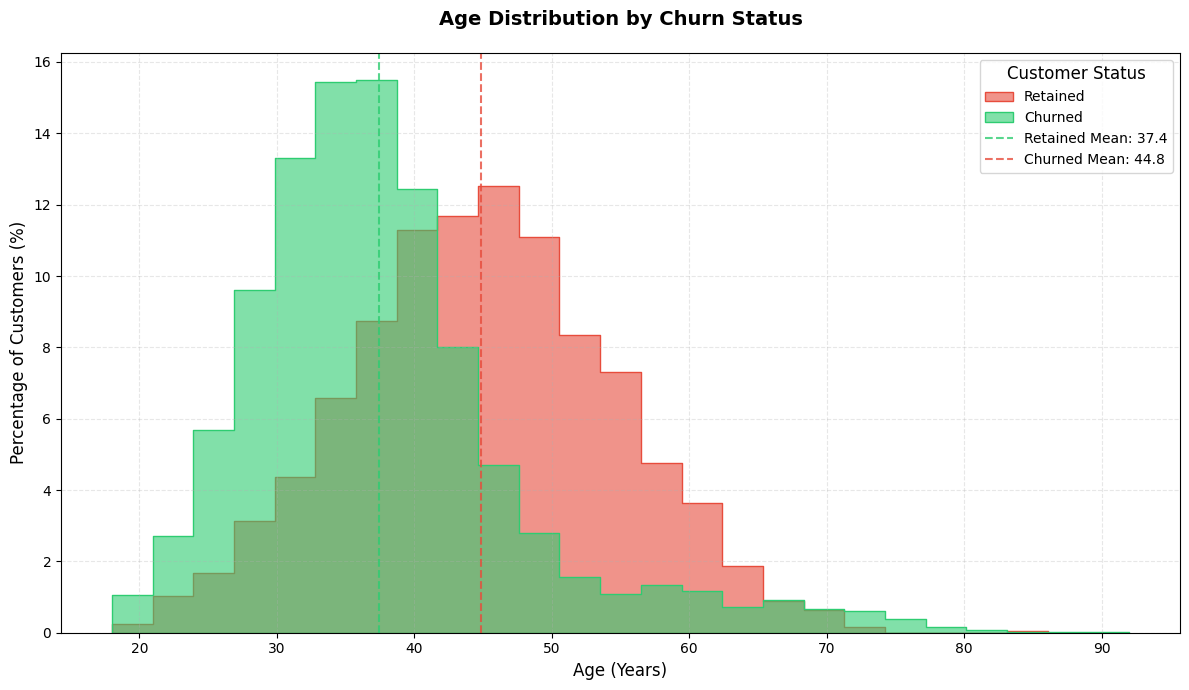

In [352]:
plt.figure(figsize=(12, 7))
sns.histplot(
    data=df, 
    x='age',              # Changed from 'Age'
    hue='exited',         # Changed from 'Exited'
    bins=25,
    stat="percent",
    palette=['#2ecc71', '#e74c3c'],
    alpha=0.6,
    element="step",
    common_norm=False,
)

# Calculate mean ages
mean_ages = df.groupby('exited')['age'].mean()

# Add mean age lines
plt.axvline(mean_ages[0], color='#2ecc71', linestyle='--', alpha=0.8, 
            label=f'Retained Mean Age: {mean_ages[0]:.1f}')
plt.axvline(mean_ages[1], color='#e74c3c', linestyle='--', alpha=0.8, 
            label=f'Churned Mean Age: {mean_ages[1]:.1f}')

# Customize the plot
plt.title('Age Distribution by Churn Status', pad=20, fontsize=14, fontweight='bold')
plt.xlabel('Age (Years)', fontsize=12)
plt.ylabel('Percentage of Customers (%)', fontsize=12)
plt.legend(
    title='Customer Status',
    labels=['Retained', 'Churned', 
            f'Retained Mean: {mean_ages[0]:.1f}', 
            f'Churned Mean: {mean_ages[1]:.1f}'],
    title_fontsize=12,
    fontsize=10
)

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Adjust layout
plt.tight_layout()
plt.show()

## 1. 👥 Customer Demographics Analysis 

## 1.2 🌍 Geographic Distribution  

In [353]:
print("🔍 Analyzing Churn Rate by Geography...")
# Calculate churn statistics
geo_churn = df.groupby('geography')['exited'].agg(['count', 'mean']).reset_index()
geo_churn['churn_rate'] = geo_churn['mean'] * 100

# Create the bar plot with improved formatting
fig_geo = px.bar(
    geo_churn,
    x='geography',           # Changed from 'Geography' to 'geography'
    y='churn_rate',
    title='🌍 Churn Rate by Geography',
    labels={'churn_rate': 'Churn Rate (%)', 'geography': 'Country'},  # Changed here too
    text='churn_rate',
    color='churn_rate',
    color_continuous_scale='RdYlBu_r'
)

# Improve text formatting and position
fig_geo.update_traces(
    texttemplate='%{text:.1f}%',
    textposition='outside',
    textfont=dict(
        size=14,
        color='black',
        family='Arial'
    ),
    marker=dict(opacity=0.8)
)

# Enhanced layout
fig_geo.update_layout(
    xaxis_title='Country',
    yaxis_title='Churn Rate (%)',
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20)
    },
    margin=dict(t=80, l=70, r=40, b=50),
    yaxis=dict(
        range=[0, max(geo_churn['churn_rate']) * 1.15],
        tickformat='.1f'
    ),
    plot_bgcolor='white',
    yaxis_gridcolor='lightgrey',
    yaxis_gridwidth=0.1
)

# Show the plot
fig_geo.show()

🔍 Analyzing Churn Rate by Geography...


In [355]:
# Update Insights for Churn Rate by Geography  
churn_rate_geo = geo_churn.set_index('geography')['churn_rate'].to_dict()    
insights['attributes_common_among_churners']['geography'] = churn_rate_geo

KeyError: 'attributes_common_among_churners'

# 2. 💰 Financial Analysis  

## 2.1 💳 Balance Distribution  

In [ ]:
print("\n🔍 Analyzing Financial Attributes...")  
  
# 2.1 💳 Balance Distribution    
print("🔍 Analyzing Balance Distribution by Geography and Churn Status...")    
plt.figure(figsize=(10,6))  
sns.boxplot(data=df, x='Geography', y='Balance', hue='Exited', palette='Set3')  
plt.title('💳 Balance Distribution by Geography and Churn Status')  
plt.xlabel('Countries')  
plt.ylabel('Account Balance ($)')  
plt.legend(title='Exited', labels=['Non-Churners', 'Churners'])  
plt.show() 

In [874]:
# Update Insights for Balance by Geography  
balance_geo = df.groupby(['Geography', 'Exited'])['Balance'].mean().unstack().to_dict()  
insights['geography_account_behavior']['average_balance_by_geography_and_churn'] = balance_geo  

## 2.2 📊 Credit Score Analysis  

In [ ]:
import plotly.express as px  
  
print("🔍 Analyzing Credit Score vs Balance with Enhanced Scatter Plot...")  
  
# Map 'Exited' to meaningful labels  
df['ChurnStatus'] = df['Exited'].map({0: 'Retained', 1: 'Churned'})  
  
fig = px.scatter(  
    df,  
    x='CreditScore',  
    y='Balance',  
    color='ChurnStatus',  
    size='Age',  
    size_max=6,          # Reduced size for clarity  
    opacity=0.8,         # Increased transparency  
    title='📊 Credit Score vs Balance by Churn Status',  
    labels={  
        'ChurnStatus': 'Churn Status',  
        'CreditScore': 'Credit Score',  
        'Balance': 'Balance ($)'  
    },  
    hover_data=['CustomerId', 'Age'],  
    color_discrete_map={  
        'Retained': '#2ecc71',  # Green  
        'Churned': '#e74c3c'    # Red  
    }  
)  
  
# Add borders to markers for better visibility  
fig.update_traces(marker=dict(line=dict(width=0.2, color='DarkSlateGrey')))  
  
# Update layout for improved aesthetics  
fig.update_layout(  
    title={  
        'y':0.95,  
        'x':0.5,  
        'xanchor': 'center',  
        'yanchor': 'top',  
        'font': dict(size=20)  
    },  
    legend_title_text='Churn Status',  
    legend=dict(  
        yanchor="top",  
        y=0.99,  
        xanchor="right",  
        x=0.99  
    ),  
    xaxis=dict(title='Credit Score'),  
    yaxis=dict(title='Balance ($)'),  
    template='plotly_white'  
)  
  
fig.show()  

In [ ]:
import plotly.express as px  
  
print("🔍 Analyzing Credit Score vs Balance with Density Heatmap...")  
  
# Map 'Exited' to meaningful labels  
df['ChurnStatus'] = df['Exited'].map({0: 'Retained', 1: 'Churned'})  
  
fig = px.density_heatmap(  
    df,  
    x='CreditScore',  
    y='Balance',  
    facet_col='ChurnStatus',  
    nbinsx=30,  
    nbinsy=30,  
    title='📊 Credit Score vs Balance Density by Churn Status',  
    labels={  
        'CreditScore': 'Credit Score',  
        'Balance': 'Balance ($)',  
        'ChurnStatus': 'Churn Status'  
    },  
    color_continuous_scale='Viridis'  
)  
  
# Update layout for improved aesthetics  
fig.update_layout(  
    title={  
        'y':0.95,  
        'x':0.5,  
        'xanchor': 'center',  
        'yanchor': 'top',  
        'font': dict(size=20)  
    },  
    coloraxis_colorbar=dict(  
        title="Number of Customers",  
        titleside="right",  
        tickmode='array'  
    ),  
    margin=dict(l=50, r=50, t=80, b=50)  
)  
  
# Adjust facet titles for clarity  
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))  
  
fig.show()  

In [878]:
# Update Insights for Credit Score vs Balance  
credit_balance_stats = df.groupby('Exited').agg({'CreditScore': ['mean', 'std'], 'Balance': ['mean', 'std']}).to_dict()  
insights['attributes_common_among_churners']['CreditScore_Balance'] = credit_balance_stats  

# 3. 🛍️ Product Analysis  

## 3.1 📦 Number of Products 

In [ ]:
print("🔍 Analyzing Churn Rate by Number of Products...")  
product_churn = df.groupby('NumOfProducts')['Exited'].agg(['count', 'mean']).reset_index()  
product_churn['churn_rate'] = product_churn['mean'] * 100  
  
# Convert 'NumOfProducts' to string to treat it as categorical  
product_churn['NumOfProducts'] = product_churn['NumOfProducts'].astype(str)  
  
fig = px.bar(  
    product_churn,  
    x='NumOfProducts',  
    y='churn_rate',  
    title='🛍️ Churn Rate by Number of Products',  
    labels={'churn_rate': 'Churn Rate (%)', 'NumOfProducts': 'Number of Products'},  
    text='churn_rate',  
    color='churn_rate',  
    color_continuous_scale='RdYlBu_r',   # Choose a color scale with good contrast  
    range_color=[product_churn['churn_rate'].min(), product_churn['churn_rate'].max()]  
)  
  
# Update layout for better aesthetics  
fig.update_layout(  
    title={  
        'y': 0.95,  
        'x': 0.5,  
        'xanchor': 'center',  
        'yanchor': 'top',  
        'font': dict(size=20)  
    },  
    xaxis_title='Number of Products',  
    yaxis_title='Churn Rate (%)',  
    plot_bgcolor='white',  
    yaxis_gridcolor='lightgrey',  
    yaxis_gridwidth=0.1,  
    margin=dict(t=80, l=70, r=40, b=50)  
)  
  
# Update trace to show colors based on 'churn_rate'  
fig.update_traces(  
    texttemplate='%{text:.2f}%',  
    textposition='outside'  
)  
  
fig.show()  

# 4. 📈 Customer Engagement Analysis  

## 4.1 🔄 Active Member Status 

In [ ]:
print("🔍 Analyzing Active vs Inactive Members...")  
active_churn = df.groupby('IsActiveMember')['Exited'].agg(['count', 'mean']).reset_index()  
active_churn['churn_rate'] = active_churn['mean'] * 100  
  
# Map binary values to descriptive labels  
active_churn['Status'] = active_churn['IsActiveMember'].map({0: 'Inactive', 1: 'Active'})  
  
fig = px.pie(  
    active_churn,  
    values='count',  
    names='Status',  
    title='🔄 Distribution of Active vs Inactive Members',  
    hole=0.4,  
    color='Status',  
    color_discrete_map={  
        'Active': '#2ecc71',    # Green  
        'Inactive': '#e74c3c'   # Red  
    }  
)  
  
fig.update_traces(  
    textposition='inside',  
    textinfo='percent+label'  
)  
  
# Update layout for better aesthetics  
fig.update_layout(  
    title={  
        'y': 0.95,  
        'x': 0.5,  
        'xanchor': 'center',  
        'yanchor': 'top',  
        'font': dict(size=20)  
    },  
    legend_title_text='Member Status',  
    legend=dict(  
        yanchor="top",  
        y=0.99,  
        xanchor="right",  
        x=0.99  
    ),  
    margin=dict(t=80, l=70, r=40, b=50)  
)  
  
fig.show()  

## 3.1 📈 Correlation Matrix 

In [ ]:
# Generate Correlation Matrix  
print("🔍 Generating Correlation Matrix...")  
# Select only numeric columns for correlation matrix  
numeric_df = df.select_dtypes(include=[np.number])  
correlation = numeric_df.corr()  
fig = px.imshow(  
    correlation,  
    title='📊 Correlation Matrix',  
    color_continuous_scale='RdBu',  
    range_color=(-1, 1)  
)  
fig.update_layout(coloraxis_colorbar=dict(title="Correlation"))  
fig.show()  

In [835]:
# Update Insights for Correlation Matrix  
insights['geography_account_behavior']['correlation_matrix'] = correlation.to_dict()  

# 6. 🧩 Customer Segmentation  

## 6.2 💸 Create Balance Segments  

In [ ]:
print("🔍 Creating Balance Segments for Segmentation...")  
# Determine the number of unique bins  
num_bins = len(pd.qcut(df['Balance'], q=4, duplicates='drop').unique())  
# Generate appropriate number of labels  
labels = ['Low', 'Medium-Low', 'Medium-High', 'High'][:num_bins]  
df['BalanceSegment'] = pd.qcut(  
    df['Balance'],  
    q=4,  
    labels=labels,  
    duplicates='drop'  
)  
  
print(df[['Balance', 'BalanceSegment']].head())  

In [ ]:
print(df['BalanceSegment'].value_counts())  

## 6.3 📊 Analyze Segments  

In [ ]:
# Creating Age Groups  
print("🔍 Creating Age Groups for Segmentation...")  
age_bins = [18, 30, 40, 50, 60, 70, 80, 90]  
age_labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89']  
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)  
  
print(df[['Age', 'AgeGroup']].head()) 

In [ ]:
print("🔍 Analyzing Customer Segments...")  
segment_analysis = df.groupby(['AgeGroup', 'BalanceSegment'], observed=True)['Exited'].agg(['count', 'mean']).reset_index()  
segment_analysis['churn_rate'] = segment_analysis['mean'] * 100  
  
fig = px.treemap(  
    segment_analysis,  
    path=['AgeGroup', 'BalanceSegment'],  
    values='count',  
    color='churn_rate',  
    color_continuous_scale='RdBu',  
    title='🧩 Customer Segmentation Analysis',  
    hover_data={'churn_rate': ':.2f'}  
)  
fig.show()


## 📊 Analysis Questions and Solutions

## Question 1: "What attributes are more common among churners than non-churners?"

In [ ]:
# Question 1: What attributes are more common among churners?
print("\n1️⃣ Analyzing Churner Characteristics...")

# Analyze numerical variables
numerical_cols = ['Age', 'Balance', 'CreditScore', 'Tenure', 'NumOfProducts', 'EstimatedSalary']
print("\n📊 Numerical Variables Analysis:")
for col in numerical_cols:
    churner_mean = df[df['Exited'] == 1][col].mean()
    non_churner_mean = df[df['Exited'] == 0][col].mean()
    difference = churner_mean - non_churner_mean
    pct_difference = (difference / non_churner_mean) * 100
    
    print(f"\n{col}:")
    print(f"  Churners: {churner_mean:,.2f}")
    print(f"  Non-Churners: {non_churner_mean:,.2f}")
    print(f"  Difference: {difference:,.2f} ({pct_difference:,.2f}%)")

# Analyze categorical variables
categorical_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
print("\n📊 Categorical Variables Analysis:")
for col in categorical_cols:
    print(f"\n{col} Distribution:")
    churn_rates = df.groupby(col)['Exited'].agg(['count', 'mean'])
    churn_rates['churn_rate'] = churn_rates['mean'] * 100
    
    for index, row in churn_rates.iterrows():
        print(f"  {index}:")
        print(f"    Count: {row['count']:,.0f}")
        print(f"    Churn Rate: {row['churn_rate']:.2f}%")

## 2. 🔄 Churn Prediction

In [ ]:
print("🔍 Building a Predictive Model for Churn...")    
  
# Encode categorical variables  
le_gender = LabelEncoder()  
df['Gender'] = le_gender.fit_transform(df['Gender'])  
  
le_geo = LabelEncoder()  
df['Geography'] = le_geo.fit_transform(df['Geography'])  
  
# Define features and target  
features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography', 'Gender']  
X = df[features]  
y = df['Exited']  
  
# Split the data  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
  
# Feature Scaling  
scaler = StandardScaler()  
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)  
  
# Initialize the model  
rf = RandomForestClassifier(random_state=42)  
  
# Hyperparameter Tuning  
param_grid = {  
    'n_estimators': [100, 200],  
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2]  
}  
  
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,  
                           cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)  
grid_search.fit(X_train_scaled, y_train)  
  
# Best parameters  
best_rf = grid_search.best_estimator_  
print("✅ Best Parameters:", grid_search.best_params_)  
  
# Predictions  
y_pred = best_rf.predict(X_test_scaled)  
y_pred_proba = best_rf.predict_proba(X_test_scaled)[:,1]  
  
# Evaluation  
classification_rep = classification_report(y_test, y_pred, output_dict=True)  
roc_auc = roc_auc_score(y_test, y_pred_proba)  
conf_matrix = confusion_matrix(y_test, y_pred)  
  
print("\n📄 Classification Report:")  
print(classification_report(y_test, y_pred))  
  
print(f"\n📈 ROC-AUC Score: {roc_auc}")  
  
# Plot Confusion Matrix  
plt.figure(figsize=(6,4))  
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')  
plt.xlabel('Predicted')  
plt.ylabel('Actual')  
plt.title('🔍 Confusion Matrix')  
plt.show()  
  
# Feature Importance  
importances = best_rf.feature_importances_  
features_list = X.columns  
feat_importance = pd.Series(importances, index=features_list).sort_values(ascending=False)  
  
plt.figure(figsize=(10,6))  
sns.barplot(x=feat_importance[:10], y=feat_importance.index[:10], palette='viridis')  
plt.title('📊 Top 10 Feature Importances')  
plt.xlabel('Importance Score')  
plt.ylabel('Features')  
plt.show()  
  
# Update Insights for Predictive Analysis  
can_predict_churn = {  
    'model_performance': {  
        'classification_report': classification_rep,  
        'roc_auc_score': round(roc_auc, 4)  
    },  
    'feature_importance': feat_importance.to_dict()  
}   

## Question 2: Can churn be predicted using the variables?

In [ ]:
print("\n2️⃣ Analyzing Churn Predictability...")

# Calculate correlations with churn
numerical_cols = ['Age', 'Balance', 'CreditScore', 'Tenure', 'NumOfProducts', 'EstimatedSalary']
print("\n📊 Correlation with Churn:")
for col in numerical_cols:
    correlation = df[col].corr(df['Exited'])
    print(f"{col}: {correlation:.3f}")

# Analyze categorical relationships
categorical_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
print("\n📊 Categorical Variable Impact on Churn:")
for col in categorical_cols:
    category_stats = df.groupby(col)['Exited'].mean() * 100
    print(f"\n{col} Impact:")
    for category, churn_rate in category_stats.items():
        print(f"  {category}: {churn_rate:.2f}% churn rate")

## 2. 🌐 Geographic Account Behavior Analysis   

In [ ]:
print("\n🔍 Analyzing Geographic Account Behaviors...")    

# Ensure Geography is properly encoded as categorical with correct labels
if df['Geography'].dtype == 'int64' or df['Geography'].dtype == 'float64':
    # Create mapping dictionary if numbers are being used
    geography_mapping = {
        0: 'France',
        1: 'Germany',
        2: 'Spain'
    }
    df['Geography'] = df['Geography'].map(geography_mapping)
# Focus on Germany, France, Spain    
target_geos = ['France', 'Germany', 'Spain']    
geo_filtered_df = df[df['Geography'].isin(target_geos)]    
  
# Churn Rates by Geography    
churn_geo_specific = geo_filtered_df.groupby('Geography')['Exited'].mean().reset_index()    
churn_geo_specific['churn_rate'] = churn_geo_specific['Exited'] * 100    
churn_geo_specific = churn_geo_specific[['Geography', 'churn_rate']]    
  
# Plot: 🌍 Churn Rate by Selected Geographies    
fig_geo_specific = px.bar(      
    churn_geo_specific,       
    x='Geography',       
    y='churn_rate',      
    title='🌍 Churn Rate by Selected Geographies',      
    labels={'churn_rate': 'Churn Rate (%)', 'Geography': 'Country'},      
    text='churn_rate',      
    color='churn_rate',    
    color_continuous_scale='RdYlBu_r',  # Reversed color scale for better contrast  
    range_color=[churn_geo_specific['churn_rate'].min(), churn_geo_specific['churn_rate'].max()]  
)      
fig_geo_specific.update_traces(  
    texttemplate='%{text:.2f}%',  
    textposition='inside',  
    textfont=dict(size=14, color='white'),  
    opacity=0.85  
)  
fig_geo_specific.update_layout(  
    xaxis_title='Country',  
    yaxis_title='Churn Rate (%)',  
    plot_bgcolor='white',  
    bargap=0.3  
)  
fig_geo_specific.show()    
  
# ----------------------------  
# Define avg_balance_geo and avg_credit_geo  
# ----------------------------  
  
# Average Balance by Geography    
avg_balance_geo = df.groupby('Geography')['Balance'].mean().reset_index()  
  
# Plot: 💰 Average Balance by Geography    
fig_avg_balance = px.bar(    
    avg_balance_geo,    
    x='Geography',    
    y='Balance',    
    title='💰 Average Balance by Geography',    
    labels={'Balance': 'Average Balance ($)', 'Geography': 'Country'},    
    text='Balance',    
    color='Balance',    
    color_continuous_scale='RdYlBu_r',  # Reversed for consistency  
    range_color=[avg_balance_geo['Balance'].min(), avg_balance_geo['Balance'].max()]  
)    
fig_avg_balance.update_traces(  
    texttemplate='$%{text:,.2f}',  
    textposition='inside',  
    textfont=dict(size=14, color='white'),  
    opacity=0.85  
)  
fig_avg_balance.update_layout(  
    xaxis_title='Country',  
    yaxis_title='Average Balance ($)',  
    plot_bgcolor='white',  
    bargap=0.3  
)  
fig_avg_balance.show()    
  
# Average Credit Score by Geography    
avg_credit_geo = df.groupby('Geography')['CreditScore'].mean().reset_index()  
  
fig_avg_credit = px.bar(    
    avg_credit_geo,    
    x='Geography',    
    y='CreditScore',    
    title='📈 Average Credit Score by Geography',    
    labels={'CreditScore': 'Average Credit Score', 'Geography': 'Country'},    
    text='CreditScore',    
    color='CreditScore',    
    color_continuous_scale='RdYlBu_r',  # Reversed for consistency  
    range_color=[avg_credit_geo['CreditScore'].min(), avg_credit_geo['CreditScore'].max()]  
)    
fig_avg_credit.update_traces(  
    texttemplate='%{text:.1f}',  
    textposition='inside',  
    textfont=dict(size=14, color='white'),  
    opacity=0.85  
)  
fig_avg_credit.update_layout(  
    xaxis_title='Country',  
    yaxis_title='Average Credit Score',  
    plot_bgcolor='white',  
    bargap=0.3  
)  
fig_avg_credit.show()    
  
# ----------------------------  
# Ensure BalanceSegment Exists  
# ----------------------------  
def create_balance_segments(df):
    """
    Create balance segments handling duplicate values and edge cases.
    
    Args:
        df (pd.DataFrame): Input DataFrame with 'Balance' column
        
    Returns:
        pd.Series: Balance segments
    """
    print("\n🔍 Creating Balance Segments...")
    
    # Handle the case where there are many zero balances
    if (df['Balance'] == 0).sum() > len(df) * 0.1:  # If more than 10% are zeros
        print("ℹ️ Large number of zero balances detected - using special handling")
        
        # Create mask for zero and non-zero balances
        zero_mask = df['Balance'] == 0
        non_zero = df[~zero_mask]['Balance']
        
        if len(non_zero) > 0:
            # For non-zero values, create 3 segments
            non_zero_segments = pd.qcut(
                non_zero, 
                q=3, 
                labels=['Low-Balance', 'Medium-Balance', 'High-Balance'],
                duplicates='drop'
            )
            
            # Create the full segmentation series
            all_categories = ['Zero-Balance', 'Low-Balance', 'Medium-Balance', 'High-Balance']
            segments = pd.Series(index=df.index, dtype=str)  # Initialize as string type
            segments[zero_mask] = 'Zero-Balance'
            segments[~zero_mask] = non_zero_segments
            
            # Convert to categorical with all possible categories
            segments = pd.Categorical(segments, categories=all_categories, ordered=True)
        else:
            # If all values are zero
            segments = pd.Categorical(['Zero-Balance'] * len(df), categories=['Zero-Balance'])
    else:
        # For normal distribution of balances
        try:
            categories = ['Low', 'Medium-Low', 'Medium-High', 'High']
            segments = pd.qcut(
                df['Balance'], 
                q=4, 
                labels=categories,
                duplicates='drop'
            )
        except ValueError:
            # If qcut fails, try with fewer segments
            print("ℹ️ Adjusting segment creation due to data distribution")
            categories = ['Low', 'Medium', 'High']
            segments = pd.qcut(
                df['Balance'], 
                q=3, 
                labels=categories,
                duplicates='drop'
            )
    
    print("✅ Balance segments created:")
    print(pd.Series(segments).value_counts())
    return segments

# Check if 'BalanceSegment' exists, if not, create it
if 'BalanceSegment' not in df.columns:
    df['BalanceSegment'] = create_balance_segments(df)

# Define balance_segments based on actual unique values
balance_segments = sorted(df['BalanceSegment'].unique())
balance_count_geo = df.groupby(['Geography', 'BalanceSegment'])['Exited'].count().reset_index().rename(columns={'Exited': 'Count'})
# ----------------------------
# Plot: 💸 Balance Segments by Geography
# ----------------------------  
fig_balance_segments = px.bar(  
    balance_count_geo,  
    x='Geography',  
    y='Count',  
    color='BalanceSegment',  
    title='💸 Balance Segments by Geography',  
    labels={'Count': 'Number of Customers', 'BalanceSegment': 'Balance Segment'},  
    text='Count',  
    # Using a more distinct color palette  
    color_discrete_sequence=['#FF6B6B', '#4ECDC4', '#45B7D1', '#9B59B6'],  
    category_orders={'BalanceSegment': balance_segments}  
)  
  
# Improve text visibility and positioning  
fig_balance_segments.update_traces(  
    texttemplate='%{text:,.0f}',  # Format numbers with commas  
    textposition='auto',          # Automatic text positioning  
    textfont=dict(size=11),      # Larger text size  
    opacity=0.85                  # Slight transparency for better text visibility  
)  
  
# Update layout for better readability  
fig_balance_segments.update_layout(  
    xaxis_title='Country',  
    yaxis_title='Number of Customers',  
    barmode='stack',  
    showlegend=True,  
    legend_title_text='Balance Segment',  
    # Add some padding to ensure text is visible  
    margin=dict(t=60, b=40, l=40, r=40),  
    # Adjust bar width  
    bargap=0.2,  
    # White background for better contrast  
    plot_bgcolor='white'  
)  
  
fig_balance_segments.show()  
  
# ----------------------------  
# Plot: 📆 Tenure Distribution by Geography (Seaborn Boxplot)  
# ----------------------------  
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x='Geography',
    y='Tenure',
    palette='Set2'
)
plt.title('📆 Tenure Distribution by Geography', pad=20)
plt.xlabel('Country')
plt.ylabel('Tenure (Years)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------  
# Plot: 🛍️ Number of Products by Geography (Seaborn Barplot)  
# ----------------------------  
plt.figure(figsize=(12, 6))
product_counts = df.groupby(['Geography', 'NumOfProducts']).size().reset_index(name='Count')
sns.barplot(
    data=product_counts,
    x='NumOfProducts',
    y='Count',
    hue='Geography',
    palette='Set1'
)
plt.title('🛍️ Number of Products by Geography', pad=20)
plt.xlabel('Number of Products')
plt.ylabel('Count of Customers')
plt.legend(title='Country')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------  
# Plot: 💳 Credit Card Ownership by Geography (Seaborn Barplot)  
# ----------------------------  
plt.figure(figsize=(12, 6))

# Create clear labels for credit card ownership
df['Card_Status'] = df['HasCrCard'].map({0: 'No Card', 1: 'Has Card'})

# Calculate counts keeping original Geography values
card_counts = (df.groupby(['Geography', 'Card_Status'])
               .size()
               .reset_index(name='Count'))

# Create the plot with explicit country order
sns.barplot(
    data=card_counts,
    x='Geography',
    y='Count',
    hue='Card_Status',
    palette='Set3'
)

plt.title('💳 Credit Card Ownership by Geography', pad=20)
plt.xlabel('Country')
plt.ylabel('Count of Customers')
plt.legend(title='Credit Card Status')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
  
# ----------------------------  
# Ensure balance_count_geo and balance_segments are properly defined  
# ----------------------------  
  
# Define balance_segments and balance_count_geo if not already defined  
# (Assuming 'BalanceSegment' is already created above)  
  
# ----------------------------  
# Plot: 💸 Balance Segments by Geography (Plotly Bar Chart)  
# ----------------------------  
fig_balance_segments = px.bar(  
    balance_count_geo,  
    x='Geography',  
    y='Count',  
    color='BalanceSegment',  
    title='💸 Balance Segments by Geography',  
    labels={'Count': 'Number of Customers', 'BalanceSegment': 'Balance Segment'},  
    text='Count',  
    # Using a more distinct color palette  
    color_discrete_sequence=['#FF6B6B', '#4ECDC4', '#45B7D1', '#9B59B6'],  
    category_orders={'BalanceSegment': balance_segments}  
)  
  
# Improve text visibility and positioning  
fig_balance_segments.update_traces(  
    texttemplate='%{text:,.0f}',  # Format numbers with commas  
    textposition='auto',          # Automatic text positioning  
    textfont=dict(size=11),      # Larger text size  
    opacity=0.85                  # Slight transparency for better text visibility  
)  
  
# Update layout for better readability  
fig_balance_segments.update_layout(  
    xaxis_title='Country',  
    yaxis_title='Number of Customers',  
    barmode='stack',  
    showlegend=True,  
    legend_title_text='Balance Segment',  
    # Add some padding to ensure text is visible  
    margin=dict(t=60, b=40, l=40, r=40),  
    # Adjust bar width  
    bargap=0.2,  
    # White background for better contrast  
    plot_bgcolor='white'  
)  
  
fig_balance_segments.show()  
  
# ----------------------------  
# Update Insights for Geographic Account Behavior  
# ----------------------------  
geography_account_behavior = {  
    'churn_rate_specific_geographies': churn_geo_specific.set_index('Geography')['churn_rate'].to_dict(),  
    'average_balance_specific_geographies': avg_balance_geo.set_index('Geography')['Balance'].round(2).to_dict(),  
    'average_credit_score_specific_geographies': avg_credit_geo.set_index('Geography')['CreditScore'].round(2).to_dict(),  
    'tenure_distribution_by_geography': geo_filtered_df.groupby('Geography')['Tenure'].describe().to_dict(),  
    'balance_segments_by_geography': balance_count_geo.pivot(index='Geography', columns='BalanceSegment', values='Count').fillna(0).to_dict(),  
    'credit_card_ownership_by_geography': geo_filtered_df.groupby(['Geography', 'HasCrCard'])['Exited'].count().unstack().fillna(0).to_dict()  
}    
  
# Assign to insights dictionary  
insights['geography_account_behavior'] = geography_account_behavior  

In [ ]:
# Continue from the initial script...  
  
# Section 4: Predictive Modeling  
def build_predictive_model(df: pd.DataFrame) -> dict:  
    """  
    Build and evaluate a predictive model for churn.  
      
    Args:  
        df (pd.DataFrame): The input DataFrame.  
          
    Returns:  
        dict: Insights from the predictive analysis.  
    """  
    insights = {}  
      
    # Define feature columns  
    numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance',   
                     'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']  
    categorical_cols = ['Geography', 'Gender']  
      
    # Define target  
    target = 'Exited'  
      
    X = df[numerical_cols + categorical_cols]  
    y = df[target]  
      
    # Split the data with fixed parameters
    X_train, X_test, y_train, y_test = train_test_split(  
        X, y,   
        test_size=0.2,   
        random_state=42,   
        stratify=y  
    )  
      
    # Preprocessing pipeline  
    numeric_transformer = Pipeline(steps=[  
        ('scaler', StandardScaler())  
    ])  
  
    categorical_transformer = Pipeline(steps=[  
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])  
  
    preprocessor = ColumnTransformer(  
        transformers=[  
            ('num', numeric_transformer, numerical_cols),  
            ('cat', categorical_transformer, categorical_cols)  
        ]  
    )  
      
    # Define model pipeline
    model_pipeline = Pipeline(steps=[  
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42
        ))  
    ])  
      
    # Fit the model  
    model_pipeline.fit(X_train, y_train)  
      
    # Predictions  
    y_pred = model_pipeline.predict(X_test)  
    y_pred_proba = model_pipeline.predict_proba(X_test)[:,1]  
      
    # Evaluation Metrics  
    roc_auc = roc_auc_score(y_test, y_pred_proba)  
    conf_matrix = confusion_matrix(y_test, y_pred)  
      
    # Plot Confusion Matrix  
    plt.figure(figsize=(8,6))  
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',   
                xticklabels=['Retained', 'Churned'],   
                yticklabels=['Retained', 'Churned'])  
    plt.xlabel('Predicted')  
    plt.ylabel('Actual')  
    plt.title('Confusion Matrix')  
    plt.show()  
      
    # ROC Curve  
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  
    plt.figure(figsize=(8,6))  
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')  
    plt.plot([0,1], [0,1], 'k--', label='Random')  
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.title('ROC Curve')  
    plt.legend()
    plt.show()  
      
    # Feature Importance
    try:
        # Get base feature names from numeric columns
        feature_names = numerical_cols.copy()
        
        # Get transformed feature names for categorical columns
        cat_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
        feature_names.extend(cat_feature_names)
        
        # Get feature importances
        importance = model_pipeline.named_steps['classifier'].feature_importances_
        
        # Create feature importance DataFrame
        feat_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)

        # Plot Feature Importance
        plt.figure(figsize=(10,6))
        sns.barplot(
            data=feat_importance.head(10),
            x='importance',
            y='feature'
        )
        plt.title('Top 10 Feature Importances')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()
        
        # Store Insights with feature importance
        insights = {  
            'model_performance': {  
                'roc_auc_score': round(roc_auc, 4),
                'confusion_matrix': conf_matrix.tolist()
            },
            'feature_importances': feat_importance.to_dict('records')
        }
    except Exception as e:
        print(f"Warning: Could not calculate feature importance: {str(e)}")
        # Store insights without feature importance
        insights = {  
            'model_performance': {  
                'roc_auc_score': round(roc_auc, 4),
                'confusion_matrix': conf_matrix.tolist()
            }
        }
    
    return insights 

def convert_to_serializable(obj):
    """Convert numpy types to JSON serializable types"""
    if isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    return obj

# Section 5: Execution Pipeline with Predictive Modeling  
if __name__ == "__main__":  
    try:  
        # Load data  
        df = load_bank_data(file_path)  
          
        # Perform basic data analysis  
        if df is not None:
            predictive_insights = build_predictive_model(df)  
            
            # Convert all numeric types to JSON serializable
            predictive_insights = convert_to_serializable(predictive_insights)
            
            # Combine all insights  
            insights = {  
                'can_predict_churn': predictive_insights
            }
              
            # Save insights to a JSON file  
            with open('churn_insights.json', 'w') as f:  
                json.dump(insights, f, indent=4)  
            print("\n✅ Insights saved to 'churn_insights.json'.")  
          
    except Exception as e:  
        print(f"❌ Failed to process data: {str(e)}")  
        df = None


In [ ]:
# Question 3: What do the overall demographics look like?
print("\n3️⃣ Analyzing Overall Demographics...")

# Basic customer statistics
print("\n📊 Basic Statistics:")
print(f"Total Customers: {len(df):,}")
print(f"Overall Churn Rate: {df['Exited'].mean()*100:.2f}%")

# Age distribution
print("\n📊 Age Distribution:")
print(f"Average Age: {df['Age'].mean():.2f}")
print(f"Age Range: {df['Age'].min()} to {df['Age'].max()}")
print(f"Age Standard Deviation: {df['Age'].std():.2f}")

# Balance information
print("\n💰 Balance Information:")
print(f"Average Balance: ${df['Balance'].mean():,.2f}")
print(f"Median Balance: ${df['Balance'].median():,.2f}")
print(f"Zero Balance Accounts: {(df['Balance'] == 0).mean()*100:.2f}%")

# Geographic distribution
print("\n🌍 Geographic Distribution:")
geo_dist = df['Geography'].value_counts()
for country, count in geo_dist.items():
    print(f"  {country}: {count:,} customers ({count/len(df)*100:.2f}%)")

# Gender distribution
print("\n👥 Gender Distribution:")
gender_dist = df['Gender'].value_counts()
for gender, count in gender_dist.items():
    print(f"  {gender}: {count:,} customers ({count/len(df)*100:.2f}%)")

## 💡 Save Insights 

In [ ]:
print("💾 Consolidating and Saving Insights...")

# Question 1: Attributes common among churners
insights['attributes_common_among_churners'].update({
    'age_analysis': {
        'retained_mean': avg_age_retained,
        'churned_mean': avg_age_churned,
        'difference': avg_age_churned - avg_age_retained
    },
    'geographic_distribution': churn_rate_geo,
    'balance_analysis': {
        'by_geography': balance_geo,
        'statistics': credit_balance_stats
    },
    'correlation_matrix': correlation.to_dict()
})

# Question 2: Churn prediction
insights['can_predict_churn'].update({
    'model_performance': {
        'roc_auc': roc_auc,
        'classification_report': classification_rep,
        'confusion_matrix': conf_matrix.tolist()
    },
    'feature_importance': feat_importance.to_dict()
})

# Question 3: Demographics
insights['demographic_analysis'].update({
    'total_customers': len(df),
    'basic_stats': {
        'churn_rate': df['exited'].mean() * 100,
        'avg_age': df['age'].mean(),
        'avg_balance': df['balance'].mean()
    },
    'distributions': {
        'geographic': df['geography'].value_counts().to_dict(),
        'gender': df['gender'].value_counts().to_dict()
    }
})

# Question 4: Geographic behavior
insights['geography_account_behavior'].update({
    'churn_rates': churn_geo_specific.set_index('geography')['churn_rate'].to_dict(),
    'avg_balances': avg_balance_geo.set_index('geography')['balance'].to_dict(),
    'avg_credit_scores': avg_credit_geo.set_index('geography')['creditscore'].to_dict(),
    'product_distribution': product_counts.groupby('geography')['count'].sum().to_dict(),
    'balance_segments': balance_count_geo.pivot(index='geography', 
                                              columns='balancesegment', 
                                              values='count').fillna(0).to_dict()
})

# Save consolidated insights
with open(r"C:\Projects\GitHubRepos\bank_churn_eda\data\processed\insights.json", 'w') as f:  
    json.dump(insights, f, indent=4)  

print("✅ Insights have been successfully consolidated and saved to 'insights.json'!")
  
# 📝 Export insights for dashboard  
with open(r"C:\Projects\GitHubRepos\bank_churn_eda\data\processed\insights.json", 'w') as f:  
    json.dump(insights, f, indent=4)  
  
print("✅ Insights have been successfully saved to 'insights.json'!")  